In [1]:
import pandas as pd
import numpy as np
import os
from datetime import timedelta 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns
import glob
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
RootPath = r"D:\Hagar\Documents\uOttawa\Second Term\ELG7186 -  AI for Cyber Security\4- Project\elg7186-project-group_project_-3\data\raw"
AnswersPATH = os.path.join(RootPath,'answers')
DataSetPath = r"D:\Hagar\Documents\uOttawa\Second Term\ELG7186 -  AI for Cyber Security\4- Project\elg7186-project-group_project_-3\data\raw"

In [3]:
DATASET_VER = 5.2
insiders_df = pd.read_csv(os.path.join(AnswersPATH,"insiders.csv"))
insiders_df = insiders_df[(insiders_df['dataset'] == DATASET_VER)]
insiders_df['start'] = pd.to_datetime(insiders_df['start'])
insiders_df = insiders_df.sort_values(by='start', ascending=True)
insiders_df.head()

dataset  scenario             details     user               start  \
177      5.2         4  r5.2-4-OHS0036.csv  OHS0036 2010-04-16 12:32:57   
148      5.2         3  r5.2-3-MPF0690.csv  MPF0690 2010-06-17 10:00:38   
111      5.2         2  r5.2-2-VCF1602.csv  VCF1602 2010-06-23 15:32:14   
128      5.2         2  r5.2-2-CKP0630.csv  CKP0630 2010-06-28 08:13:30   
115      5.2         2  r5.2-2-ZIE0741.csv  ZIE0741 2010-06-29 13:16:09   

                     end  
177  07/09/2010 10:32:40  
148  06/18/2010 20:22:06  
111  08/11/2010 18:01:01  
128  08/13/2010 12:59:03  
115  08/27/2010 18:13:31

In [4]:
# get user functional dictionary
all_files = glob.glob(os.path.join(DataSetPath,"LDAP/*.csv"))
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
LDAP_df = pd.concat(li, axis=0, ignore_index=True).drop_duplicates()

print(f'length of LDAP : {len(LDAP_df)}')
LDAP_df.head(10)

length of LDAP : 3581


employee_name  user_id                              email  \
0        Maisie Maggy Kline  MMK1532        Maisie.Maggy.Kline@dtaa.com   
1         Nicole Tanya Burt  NTB0710         Nicole.Tanya.Burt@dtaa.com   
2  Madeline Tatum Donaldson  MTD0971  Madeline.Tatum.Donaldson@dtaa.com   
3  Nicholas Hamish Browning  NHB1529  Nicholas.Hamish.Browning@dtaa.com   
4           Hoyt Berk Wiley  HBW0057           Hoyt.Berk.Wiley@dtaa.com   
5     Patience Lesley Mccoy  PLM1716     Patience.Lesley.Mccoy@dtaa.com   
6        Ulric Kirk Guthrie  UKG0386        Ulric.Kirk.Guthrie@dtaa.com   
7  Guinevere Lisandra Chang  GLC1055  Guinevere.Lisandra.Chang@dtaa.com   
8       Ulric Ciaran Dunlap  UCD0608       Ulric.Ciaran.Dunlap@dtaa.com   
9        Coby Baxter Nguyen  CBN1983        Coby.Baxter.Nguyen@dtaa.com   

                      role   projects  business_unit  \
0               Technician        NaN  2 - Executive   
1  SoftwareQualityEngineer  Project 2  2 - Executive   
2       ElectricalEngineer        NaN  1 - Executive   
3               Technician        NaN  2 - Executive   
4           ProjectManager        NaN  1 - Executive   
5                 Salesman        NaN  2 - Executive   
6     ProductionLineWorker        NaN  2 - Executive   
7     ProductionLineWorker        NaN  1 - Executive   
8           StockroomClerk        NaN  1 - Executive   
9               LabManager        NaN  1 - Executive   

              functional_unit              department  \
0       5 - SalesAndMarketing        3 - FieldService   
1  2 - ResearchAndEngineering  3 - SoftwareManagement   
2  2 - ResearchAndEngineering  3 - SoftwareManagement   
3       5 - SalesAndMarketing        3 - FieldService   
4  2 - ResearchAndEngineering   1 - ProjectManagement   
5       5 - SalesAndMarketing               2 - Sales   
6           3 - Manufacturing            3 - Assembly   
7           3 - Manufacturing            3 - Assembly   
8           3 - Manufacturing            3 - Assembly   
9  2 - ResearchAndEngineering            2 - Research   

                       team                  supervisor  
0  3 - RegionalFieldService         Yvette Naomi Cortez  
1                   1 - SQA  Brennan Thaddeus Dominguez  
2      6 - EmbeddedSoftware         Todd Rajah Peterson  
3  3 - RegionalFieldService         Yvette Naomi Cortez  
4                       NaN             Rina Adena Horn  
5         4 - RegionalSales       Ethan Branden Garrett  
6          1 - AssemblyDept     Prescott Jasper Collins  
7          4 - AssemblyDept      Evangeline Yoko Malone  
8             1 - Stockroom    Sydney Genevieve Nichols  
9                   6 - Lab     Dominique Karly Charles

#**General Features**

In [5]:
from datetime import timedelta

def is_weekend(x):
    if (x == 5) or (x==6):
        return "weekend"
    else:
        return "weekday"

def is_working_hour(x):
    if(x >= 7 and x <= 18):
        return 'working_hour'
    else:
        return "after_hours"
    
def get_user_pc(x, unique_pcs):
    '''
    '''
    user = unique_pcs[unique_pcs['pc'] == x['pc']].user.values
    if(len(user)):
        return user[0]

def get_supervisor(user_id, ldap_file=LDAP_df):
    supervisor_name = ldap_file[ldap_file['user_id'] == user_id].supervisor.values[0]
    supervisor_id = ldap_file[ldap_file['employee_name'] == supervisor_name].user_id
    if(len(supervisor_id)):
      return supervisor_id.values[0]
    else:
      return None

def is_personal_pc(x, user_pcs_df):
    '''
    '''
    user_pc = user_pcs_df[user_pcs_df['user'] == x.user].pc.values[0]
    
    if(user_pc == x.pc):
        return "personal_pc"
    
    supervisor = get_supervisor(x.user)
    if(supervisor is not None):
      supervisor_pc = user_pcs_df[user_pcs_df['user'] == supervisor].pc.values[0]
      if(supervisor_pc == x.pc):
          return "supervisor_pc"
      else:
          return "other_pc"
    return "other_pc"
    
def map_user_pcs(df, time_period=15):
    '''
    '''
    user_pc_df = pd.DataFrame(columns=['pc', 'user'])
    start_date = df.date.min()
    end_date =  start_date + timedelta(days=time_period)
    
    time_period_logons = df[(df['date'] > start_date) & (df['date'] < end_date)]

    user_pc_df['pc'] = time_period_logons['pc'].unique()
    user_pc_counts = time_period_logons.groupby(['user', 'pc']).size()
    user_pc_counts = user_pc_counts.to_frame(name = 'count').reset_index()
    idxs = user_pc_counts.groupby(['user'])['count'].transform(max) == user_pc_counts['count']
    unique_pcs = user_pc_counts[idxs]
    user_pc_df['user'] = user_pc_df.apply(get_user_pc, args=[unique_pcs], axis=1)
    
    return user_pc_df.dropna()

In [6]:
all_logon_df = pd.read_csv(r"D:\Hagar\Documents\uOttawa\Second Term\ELG7186 -  AI for Cyber Security\4- Project\Dataset\r5.2\logon.csv")
all_logon_df['date'] = pd.to_datetime(all_logon_df['date'])
all_logon_df.head()

id                date     user       pc activity
0  {Q4D5-W4HH44UC-5188LWZK} 2010-01-02 02:24:51  JBI1134  PC-0168    Logon
1  {G7V0-S4TP95SA-9203AOGR} 2010-01-02 02:38:28  JBI1134  PC-0168   Logoff
2  {B4U7-K4DB84LM-2657VBFY} 2010-01-02 04:55:52  JBI1134  PC-2320    Logon
3  {K2E1-W7VG04OA-3686THSV} 2010-01-02 05:02:28  JBI1134  PC-2320   Logoff
4  {Z7B2-Z8AS75YE-4485NAFE} 2010-01-02 06:35:00  HMI1448  PC-9352    Logon

In [7]:
user_pcs_df = map_user_pcs(all_logon_df)
user_pcs_df

pc     user
0     PC-0168  KKP0064
1     PC-2320  ADR1156
2     PC-9352  HMI1448
3     PC-5439  JEH0587
4     PC-2683  KMC1934
...       ...      ...
1997  PC-3634  FWB1999
1998  PC-3877  IRN1736
1999  PC-4325  MSK0117
2000  PC-0845  PBS0120
2001  PC-4999  EJV0094

[2000 rows x 2 columns]

#**Email**

In [8]:
email_df = pd.read_csv(os.path.join(DataSetPath,'email.csv'))
email_df['date'] = pd.to_datetime(email_df['date'])
email_df.head(5)

id                date     user       pc  \
0  {Y4F7-N0DM86BL-9295AJOV} 2010-01-02 07:47:39  GVM1337  PC-6338   
1  {O6W5-S9OE61YZ-9954AAJV} 2010-01-02 07:48:39  GVM1337  PC-6338   
2  {A2G6-T7FE08CK-7601IYDT} 2010-01-02 07:50:20  GVM1337  PC-6338   
3  {V9E1-E4KG05KT-8603JHAW} 2010-01-02 07:50:40  GVM1337  PC-6338   
4  {W8E0-S2GA51NB-8855DBRL} 2010-01-02 07:51:20  GVM1337  PC-6338   

                                                  to  \
0  Paki.Kermit.Fox@dtaa.com;Xenos.Nicolas.Church@...   
1  Paki.Kermit.Fox@dtaa.com;Xenos.Nicolas.Church@...   
2                         Guinevere_A_Taylor@cox.net   
3                        Lara.Cathleen.Rich@dtaa.com   
4                         Guinevere_A_Taylor@cox.net   

                         cc                              bcc  \
0  Alan.Flynn.Pope@dtaa.com  Gregory.Victor.Mccarty@dtaa.com   
1  Alan.Flynn.Pope@dtaa.com                              NaN   
2       GVM9137@charter.net                              NaN   
3                       NaN  Gregory.Victor.Mccarty@dtaa.com   
4       GVM9137@charter.net                              NaN   

                              from activity     size  \
0  Gregory.Victor.Mccarty@dtaa.com     Send  5353488   
1  Gregory.Victor.Mccarty@dtaa.com  Receive  5353488   
2              GVM9137@charter.net     Send    22721   
3  Gregory.Victor.Mccarty@dtaa.com     Send    86054   
4              GVM9137@charter.net  Receive    22721   

                                         attachments  \
0  13.doc(1835701);army.doc(1931135);covered.jpg(...   
1  13.doc(1835701);army.doc(1931135);covered.jpg(...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                             content  
0  remind sought suffered onto conference establi...  
1  remind sought suffered onto conference establi...  
2  warned repair devastated twin passing french h...  
3  repulsed francis everything three rationalised...  
4  warned repair devastated twin passing french h...

In [100]:
email_df.activity.value_counts()

Receive    1105754
Send        531791
Name: activity, dtype: int64

In [9]:
# statistical features
def get_no_attachments_type(attachment):
    if (attachment != attachment): return 0

    types = [re.findall('\.[a-zA-Z0-9]*\(',i)[0][1:-1]for i in attachment.split(';')]
    unique_types = np.unique(np.array(types))
    return len(unique_types)

def get_attachments_size(attachment):
    if (attachment != attachment): return 0

    sizes = [int(re.findall('\([0-9]+\)',i)[0][1:-1])for i in attachment.split(';')]
    #sizes = np.array(sizes)/1024/1024
    sum_sizes = np.sum(np.array(sizes))
    return sum_sizes

def get_no_external_dest(to):
    dests_count = len(to.split(';'))
    internal_count = len(re.findall('@dtaa.com',to))
    return dests_count - internal_count

def is_external_mail(to):
    if to != to : return False

    dests_count = len(to.split(';'))
    internal_count = len(re.findall('@dtaa.com',to))
    return (dests_count - internal_count)>0

def process_email(e_df):
    df = e_df.copy()
    # statistical features
    df['no_destinations'] = df['to'].apply(lambda x : len(x.split(';')))
    df['no_attachments'] = df['attachments'].apply(lambda x : 0 if x != x else len(x.split(';')))
    df['no_attachments_type'] = df['attachments'].apply(get_no_attachments_type)
    df['attachments_size'] = df['attachments'].apply(get_attachments_size)
    df['no_external_dest'] = df['to'].apply(get_no_external_dest)
    df['no_bcc_dest'] = df['bcc'].apply(lambda x : 0 if x != x else len(x.split(';')))
    df['no_words'] = df['content'].apply(lambda x : 0 if x != x else len(x.split(' ')))
    # df['size'] = df['size'].apply(lambda x : x/1024/1024)

    # count features
    df['is_external'] = df['to'].apply(lambda x :1 if is_external_mail(x) else 0)
    df['is_external_bcc'] = df['bcc'].apply(lambda x :1 if is_external_mail(x) else 0)

    return df

## Clustering Features

In [23]:
def internal_recepients_count(to):
    recepients = to.split(";")
    internal_recepients = [rec for rec in recepients if "dtaa" in rec]
    return len(internal_recepients)

In [36]:
def is_internal_email(to):
    recepients = to.split(";")
    internal_recepients = [rec for rec in recepients if "dtaa" in rec]
    if len(internal_recepients) == len(recepients):
        return 1
    else: 
        return 0

In [20]:
user_daily_emails = email_df.copy()
user_daily_emails["day"] = user_daily_emails["date"].dt.normalize()
user_daily_emails["hour"] = user_daily_emails["date"].dt.hour

user_daily_emails["is_working_hour"] = user_daily_emails['hour'].apply(is_working_hour)
user_daily_emails["is_personal_pc"] = user_daily_emails.apply(is_personal_pc, args=[user_pcs_df], axis=1)
user_daily_emails.head()

id       date     user       pc  \
0  {Y4F7-N0DM86BL-9295AJOV} 2010-01-02  GVM1337  PC-6338   
1  {O6W5-S9OE61YZ-9954AAJV} 2010-01-02  GVM1337  PC-6338   
2  {A2G6-T7FE08CK-7601IYDT} 2010-01-02  GVM1337  PC-6338   
3  {V9E1-E4KG05KT-8603JHAW} 2010-01-02  GVM1337  PC-6338   
4  {W8E0-S2GA51NB-8855DBRL} 2010-01-02  GVM1337  PC-6338   

                                                  to  \
0  Paki.Kermit.Fox@dtaa.com;Xenos.Nicolas.Church@...   
1  Paki.Kermit.Fox@dtaa.com;Xenos.Nicolas.Church@...   
2                         Guinevere_A_Taylor@cox.net   
3                        Lara.Cathleen.Rich@dtaa.com   
4                         Guinevere_A_Taylor@cox.net   

                         cc                              bcc  \
0  Alan.Flynn.Pope@dtaa.com  Gregory.Victor.Mccarty@dtaa.com   
1  Alan.Flynn.Pope@dtaa.com                              NaN   
2       GVM9137@charter.net                              NaN   
3                       NaN  Gregory.Victor.Mccarty@dtaa.com   
4       GVM9137@charter.net                              NaN   

                              from activity     size  \
0  Gregory.Victor.Mccarty@dtaa.com     Send  5353488   
1  Gregory.Victor.Mccarty@dtaa.com  Receive  5353488   
2              GVM9137@charter.net     Send    22721   
3  Gregory.Victor.Mccarty@dtaa.com     Send    86054   
4              GVM9137@charter.net  Receive    22721   

                                         attachments  \
0  13.doc(1835701);army.doc(1931135);covered.jpg(...   
1  13.doc(1835701);army.doc(1931135);covered.jpg(...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                             content  hour is_working_hour  \
0  remind sought suffered onto conference establi...     0     after_hours   
1  remind sought suffered onto conference establi...     0     after_hours   
2  warned repair devastated twin passing french h...     0     after_hours   
3  repulsed francis everything three rationalised...     0     after_hours   
4  warned repair devastated twin passing french h...     0     after_hours   

  is_personal_pc  
0    personal_pc  
1    personal_pc  
2    personal_pc  
3    personal_pc  
4    personal_pc

In [21]:
user_daily_emails['cc'] = user_daily_emails['cc'].replace(np.nan,'',regex=True)
user_daily_emails['bcc'] = user_daily_emails['bcc'].replace(np.nan,'',regex=True)
user_daily_emails['attachments'] = user_daily_emails['attachments'].replace(np.nan,'',regex=True)

In [75]:
user_daily_emails["send_activity"] = user_daily_emails["activity"].apply(lambda x: 1 if x == "send" else 0)
user_daily_emails["receive_activity"] = user_daily_emails["activity"].apply(lambda x: 1 if x == "receive" else 0)

user_daily_emails["working_hour"] = user_daily_emails["is_working_hour"].apply(lambda x: 1 if x == "working_hour" else 0)
user_daily_emails["after_hours"] = user_daily_emails["is_working_hour"].apply(lambda x: 1 if x == "after_hours" else 0)

user_daily_emails["user_pc"] = user_daily_emails["is_personal_pc"].apply(lambda x: 1 if x == "personal_pc" else 0)
user_daily_emails["supervisor_pc"] = user_daily_emails["is_personal_pc"].apply(lambda x: 1 if x == "supervisor_pc" else 0)
user_daily_emails["other_pc"] = user_daily_emails["is_personal_pc"].apply(lambda x: 1 if x == "other_pc" else 0)
user_daily_emails["other_pcs"] = user_daily_emails["supervisor_pc"] + user_daily_emails["other_pc"]

user_daily_emails["has_attachments"] = user_daily_emails["attachments"].apply(lambda x: 1 if len(x) > 0 else 0)
user_daily_emails["internal_recepients"] = user_daily_emails["to"].apply(internal_recepients_count)

In [37]:
user_daily_emails["Is_internal_email"] = user_daily_emails["to"].apply(is_internal_email)

In [150]:
user_daily_emails["from_internal_email"] = user_daily_emails["from"].apply(lambda x: 1 if "dtaa" in x else 0)

In [152]:
user_daily_emails["from_external_email"] = user_daily_emails["from"].apply(lambda x: 1 if "dtaa" not in x else 0)

In [28]:
def unique_recepients(to):
    daily_recepients = ";".join(to)
    daily_recepients = daily_recepients.split(";")
    return np.unique(np.array(daily_recepients)).shape[0]

In [266]:
total_daily_recepients = user_daily_emails[user_daily_emails.activity == "Send"].groupby(['date', 'user'])["to"].apply(list).to_frame().reset_index()

In [267]:
sent_daily_emails = user_daily_emails[user_daily_emails.activity == "Send"].groupby(['date', 'user']).agg(
    sent_count = ("id", "count"),
    internal_emails_count = ("Is_internal_email", sum),
    internal_recepients_count = ("internal_recepients", sum),
    sent_after_hour_count = ("after_hours", sum),
    sent_with_attachments_count = ("has_attachments", sum),
    sent_from_other_pcs_count = ("other_pcs", sum)    
).reset_index()

In [268]:
sent_daily_emails["distinct_recepients_count"] = total_daily_recepients["to"].apply(unique_recepients)

In [269]:
sent_daily_emails

date     user  sent_count  internal_emails_count  \
0     2010-01-02  ELT1370           1                      1   
1     2010-01-02  ESM1828          16                      5   
2     2010-01-02  GVM1337           9                      4   
3     2010-01-02  ILM1441           3                      1   
4     2010-01-02  IRH1224           9                      2   
...          ...      ...         ...                    ...   
61899 2011-06-01  UCC0395          14                      4   
61900 2011-06-01  WBK1077          11                      5   
61901 2011-06-01  WCW1013           9                      8   
61902 2011-06-01  WOS1834          15                      5   
61903 2011-06-01  YBD1929          15                      8   

       internal_recepients_count  sent_after_hour_count  \
0                              1                      1   
1                             12                     16   
2                              9                      9   
3                              1                      3   
4                              4                      9   
...                          ...                    ...   
61899                         10                     14   
61900                         10                     11   
61901                         17                      9   
61902                         14                     15   
61903                         21                     15   

       sent_with_attachments_count  sent_from_other_pcs_count  \
0                                0                          0   
1                                5                          0   
2                                3                          0   
3                                2                          0   
4                                2                          0   
...                            ...                        ...   
61899                            3                          0   
61900                            4                          0   
61901                            0                          0   
61902                            0                          0   
61903                            0                          0   

       distinct_recepients_count  
0                              1  
1                             23  
2                             10  
3                              4  
4                             10  
...                          ...  
61899                         19  
61900                         15  
61901                          8  
61902                         25  
61903                         24  

[61904 rows x 9 columns]

In [219]:
email_trail = user_daily_emails.groupby(['date', 'user']).id.count()

In [270]:
sent_daily_emails.to_csv("sent_daily_emails.csv", index=False)

In [271]:
received_daily_emails = user_daily_emails[user_daily_emails.activity == "Receive"].groupby(['date', 'user']).agg(
    received_count = ("id", "count"),
    internal_emails_count = ("from_internal_email", sum),
    external_emails_count = ("from_external_email", sum),
    recieved_after_hour_count = ("after_hours", sum),
    receive_with_attachments_count = ("has_attachments", sum),
    received_from_other_pcs_count = ("other_pcs", sum)    
).reset_index()

In [272]:
received_daily_emails


date     user  received_count  internal_emails_count  \
0     2010-01-02  ELT1370               1                      1   
1     2010-01-02  ESM1828              17                      6   
2     2010-01-02  GVM1337              10                      5   
3     2010-01-02  HJB1444               2                      1   
4     2010-01-02  ILM1441               3                      1   
...          ...      ...             ...                    ...   
62064 2011-06-01  WBK1077              39                     22   
62065 2011-06-01  WCW1013              21                     19   
62066 2011-06-01  WOS1834              23                     12   
62067 2011-06-01  YBD1929              16                     12   
62068 2011-06-02  KRC0098               1                      0   

       external_emails_count  recieved_after_hour_count  \
0                          0                          1   
1                         11                         17   
2                          5                         10   
3                          1                          2   
4                          2                          3   
...                      ...                        ...   
62064                     17                         39   
62065                      2                         21   
62066                     11                         23   
62067                      4                         16   
62068                      1                          1   

       receive_with_attachments_count  received_from_other_pcs_count  
0                                   0                              0  
1                                   5                              0  
2                                   3                              0  
3                                   1                              0  
4                                   2                              0  
...                               ...                            ...  
62064                               6                              0  
62065                               2                              0  
62066                               1                              0  
62067                               2                              0  
62068                               0                              0  

[62069 rows x 8 columns]

In [273]:
received_daily_emails.to_csv("received_daily_emails.csv", index=False)

In [19]:
tmp_email_df = process_email(email_df)
tmp_email_df['weekday'] = tmp_email_df.date.dt.weekday
tmp_email_df['hour'] = tmp_email_df['date'].dt.hour
tmp_email_df['day'] = pd.to_datetime(tmp_email_df['date']).dt.normalize()

tmp_email_df['is_weekend'] = tmp_email_df['weekday'].apply(is_weekend)
tmp_email_df['is_working_hour'] = tmp_email_df['hour'].apply(is_working_hour)
tmp_email_df['is_personal_pc'] = tmp_email_df.apply(is_personal_pc, args=[user_pcs_df], axis=1)

tmp_email_df.head(10)

id                date     user       pc  \
0  {Y4F7-N0DM86BL-9295AJOV} 2010-01-02 07:47:39  GVM1337  PC-6338   
1  {O6W5-S9OE61YZ-9954AAJV} 2010-01-02 07:48:39  GVM1337  PC-6338   
2  {A2G6-T7FE08CK-7601IYDT} 2010-01-02 07:50:20  GVM1337  PC-6338   
3  {V9E1-E4KG05KT-8603JHAW} 2010-01-02 07:50:40  GVM1337  PC-6338   
4  {W8E0-S2GA51NB-8855DBRL} 2010-01-02 07:51:20  GVM1337  PC-6338   
5  {V9Y4-Y6YA45RC-6762BMXK} 2010-01-02 07:51:40  GVM1337  PC-6338   
6  {F3S0-B5AP99TB-4530VMJO} 2010-01-02 08:03:57  IRH1224  PC-4126   
7  {L3U3-N0SK79WC-6849WIHK} 2010-01-02 08:04:04  IRH1224  PC-4126   
8  {U1X2-Z4AU52HO-7851KWYP} 2010-01-02 08:04:06  IRH1224  PC-4126   
9  {T1M8-A5KW20CX-6235QRKK} 2010-01-02 08:04:57  IRH1224  PC-4126   

                                                  to  \
0  Paki.Kermit.Fox@dtaa.com;Xenos.Nicolas.Church@...   
1  Paki.Kermit.Fox@dtaa.com;Xenos.Nicolas.Church@...   
2                         Guinevere_A_Taylor@cox.net   
3                        Lara.Cathleen.Rich@dtaa.com   
4                         Guinevere_A_Taylor@cox.net   
5                        Lara.Cathleen.Rich@dtaa.com   
6   Ethan.B.Garrett@yahoo.com;Stewart.Kennan@cox.net   
7                          Ethan.B.Garrett@yahoo.com   
8                          Ethan.B.Garrett@yahoo.com   
9   Ethan.B.Garrett@yahoo.com;Stewart.Kennan@cox.net   

                              cc                              bcc  \
0       Alan.Flynn.Pope@dtaa.com  Gregory.Victor.Mccarty@dtaa.com   
1       Alan.Flynn.Pope@dtaa.com                              NaN   
2            GVM9137@charter.net                              NaN   
3                            NaN  Gregory.Victor.Mccarty@dtaa.com   
4            GVM9137@charter.net                              NaN   
5                            NaN                              NaN   
6              LSM14@charter.net    Ivana.R.Holland@optonline.net   
7  Ivana.R.Holland@optonline.net                              NaN   
8                            NaN    Ivana.R.Holland@optonline.net   
9              LSM14@charter.net                              NaN   

                              from activity     size  ... no_bcc_dest  \
0  Gregory.Victor.Mccarty@dtaa.com     Send  5353488  ...           1   
1  Gregory.Victor.Mccarty@dtaa.com  Receive  5353488  ...           0   
2              GVM9137@charter.net     Send    22721  ...           0   
3  Gregory.Victor.Mccarty@dtaa.com     Send    86054  ...           1   
4              GVM9137@charter.net  Receive    22721  ...           0   
5  Gregory.Victor.Mccarty@dtaa.com  Receive    86054  ...           0   
6    Ivana.R.Holland@optonline.net     Send    26210  ...           1   
7    Ivana.R.Holland@optonline.net     Send    43652  ...           0   
8    Ivana.R.Holland@optonline.net     Send    29059  ...           1   
9    Ivana.R.Holland@optonline.net  Receive    26210  ...           0   

  no_words  is_external  is_external_bcc  weekday  hour        day  \
0       70            0                0        5     7 2010-01-02   
1       70            0                0        5     7 2010-01-02   
2       44            1                0        5     7 2010-01-02   
3       69            0                0        5     7 2010-01-02   
4       44            1                0        5     7 2010-01-02   
5       69            0                0        5     7 2010-01-02   
6       50            1                1        5     8 2010-01-02   
7       59            1                0        5     8 2010-01-02   
8       39            1                1        5     8 2010-01-02   
9       50            1                0        5     8 2010-01-02   

   is_weekend  is_working_hour  is_personal_pc  
0     weekend     working_hour     personal_pc  
1     weekend     working_hour     personal_pc  
2     weekend     working_hour     personal_pc  
3     weekend     working_hour     personal_pc  
4     weekend     working_hour     personal_pc  
5     weekend     w

**Count Features**

In [17]:
groupby_cols = ['day', 'user', 'activity', 'is_working_hour', 'is_personal_pc' ,'is_external' , 'is_external_bcc']
user_daily_email_counts = pd.DataFrame({"count" : tmp_email_df.groupby(groupby_cols).size()}).reset_index()
user_daily_email_counts = user_daily_email_counts.set_index(groupby_cols).unstack(['activity', 'is_working_hour', 'is_personal_pc' , 'is_external' , 'is_external_bcc'])
user_daily_email_counts.columns = ['{}_{}_{}_{}_{}_{}'.format(a,b,c,d,e,f) for a,b,c,d,e,f in user_daily_email_counts.columns]

user_daily_email_counts.fillna(0, inplace=True)
user_daily_email_counts = user_daily_email_counts.reset_index()
user_daily_email_counts

day     user  count_Receive_working_hour_personal_pc_0_0  \
0     2010-01-02  ELT1370                                         1.0   
1     2010-01-02  ESM1828                                         5.0   
2     2010-01-02  GVM1337                                         5.0   
3     2010-01-02  HJB1444                                         0.0   
4     2010-01-02  ILM1441                                         1.0   
...          ...      ...                                         ...   
62464 2011-06-01  WBK1077                                        18.0   
62465 2011-06-01  WCW1013                                        19.0   
62466 2011-06-01  WOS1834                                        11.0   
62467 2011-06-01  YBD1929                                         7.0   
62468 2011-06-02  KRC0098                                         0.0   

       count_Send_working_hour_personal_pc_0_0  \
0                                          1.0   
1                                          5.0   
2                                          4.0   
3                                          0.0   
4                                          1.0   
...                                        ...   
62464                                      5.0   
62465                                      8.0   
62466                                      5.0   
62467                                      8.0   
62468                                      0.0   

       count_Receive_working_hour_personal_pc_1_0  \
0                                             0.0   
1                                            12.0   
2                                             5.0   
3                                             0.0   
4                                             2.0   
...                                           ...   
62464                                        21.0   
62465                                         2.0   
62466                                        12.0   
62467                                         9.0   
62468                                         0.0   

       count_Send_working_hour_personal_pc_1_0  \
0                                          0.0   
1                                          7.0   
2                                          4.0   
3                                          0.0   
4                                          0.0   
...                                        ...   
62464                                      6.0   
62465                                      1.0   
62466                                     10.0   
62467                                      7.0   
62468                                      0.0   

       count_Send_working_hour_personal_pc_1_1  \
0                                          0.0   
1                                          4.0   
2                                          1.0   
3                                          0.0   
4                                          2.0   
...                                        ...   
62464                                      0.0   
62465                                      0.0   
62466                                      0.0   
62467                                      0.0   
62468                                      0.0   

       count_Receive_after_hours_personal_pc_0_0  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            1.0   
4                                            0.0   
...                                          ...   
62464                                        0.0   
62465                                        0.0   
62466                                        0.0   
62467                                        0.0   
62468                                        0.0   

       count_Receive_after_hours_personal_pc_1_0  \
0                  

**Statistical Features**

In [18]:
user_daily_email_stats = tmp_email_df.groupby(["day", "user"])['no_destinations', 'no_attachments','no_attachments_type',
                         'attachments_size','no_external_dest','no_bcc_dest','no_words','size'].mean().reset_index()

user_daily_email_stats.head(10)

C:\Users\Hagar\AppData\Local\Temp/ipykernel_21904/1079568989.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_daily_email_stats = tmp_email_df.groupby(["day", "user"])['no_destinations', 'no_attachments','no_attachments_type',


day     user  no_destinations  no_attachments  no_attachments_type  \
0 2010-01-02  ELT1370         1.000000        0.000000             0.000000   
1 2010-01-02  ESM1828         1.666667        0.363636             0.363636   
2 2010-01-02  GVM1337         1.526316        0.842105             0.631579   
3 2010-01-02  HJB1444         1.500000        0.500000             0.500000   
4 2010-01-02  ILM1441         1.333333        0.666667             0.666667   
5 2010-01-02  IRH1224         1.444444        0.333333             0.333333   
6 2010-01-02  JMM0613         3.000000        0.000000             0.000000   
7 2010-01-02  KRC0098         1.833333        0.555556             0.500000   
8 2010-01-02  VRP0267         1.833333        0.333333             0.333333   
9 2010-01-03  DLW1705         1.850000        0.650000             0.600000   

   attachments_size  no_external_dest  no_bcc_dest   no_words           size  
0          0.000000          0.000000     0.500000  61.000000   45721.000000  
1     307439.090909          0.939394     0.242424  47.727273  336874.696970  
2     706252.105263          0.526316     0.263158  49.368421  739370.315789  
3     135437.500000          0.500000     0.000000  42.500000  161672.500000  
4     306603.333333          1.000000     0.500000  37.666667  330746.666667  
5     247926.888889          1.000000     0.333333  50.000000  280748.222222  
6          0.000000          1.000000     0.500000  54.500000   25440.000000  
7     501808.555556          0.277778     0.250000  52.555556  533078.666667  
8     133522.916667          0.458333     0.458333  48.916667  167208.583333  
9     491340.100000          0.500000     0.000000  44.650000  519133.350000

**Merge**

In [19]:
user_daily_email = user_daily_email_counts.merge(user_daily_email_stats, on=['day', 'user'])
user_daily_email.head(10)

day     user  count_Receive_working_hour_personal_pc_0_0  \
0 2010-01-02  ELT1370                                         1.0   
1 2010-01-02  ESM1828                                         5.0   
2 2010-01-02  GVM1337                                         5.0   
3 2010-01-02  HJB1444                                         0.0   
4 2010-01-02  ILM1441                                         1.0   
5 2010-01-02  IRH1224                                         2.0   
6 2010-01-02  JMM0613                                         1.0   
7 2010-01-02  KRC0098                                        16.0   
8 2010-01-02  VRP0267                                        10.0   
9 2010-01-03  DLW1705                                         0.0   

   count_Send_working_hour_personal_pc_0_0  \
0                                      1.0   
1                                      5.0   
2                                      4.0   
3                                      0.0   
4                                      1.0   
5                                      2.0   
6                                      0.0   
7                                     16.0   
8                                      8.0   
9                                     14.0   

   count_Receive_working_hour_personal_pc_1_0  \
0                                         0.0   
1                                        12.0   
2                                         5.0   
3                                         0.0   
4                                         2.0   
5                                         7.0   
6                                         0.0   
7                                         2.0   
8                                         4.0   
9                                         4.0   

   count_Send_working_hour_personal_pc_1_0  \
0                                      0.0   
1                                      7.0   
2                                      4.0   
3                                      0.0   
4                                      0.0   
5                                      3.0   
6                                      0.0   
7                                      1.0   
8                                      1.0   
9                                      2.0   

   count_Send_working_hour_personal_pc_1_1  \
0                                      0.0   
1                                      4.0   
2                                      1.0   
3                                      0.0   
4                                      2.0   
5                                      4.0   
6                                      1.0   
7                                      1.0   
8                                      1.0   
9                                      0.0   

   count_Receive_after_hours_personal_pc_0_0  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        1.0   
4                                        0.0   
5                                        0.0   
6                                        0.0   
7                                        0.0   
8                                        0.0   
9                                        0.0   

   count_Receive_after_hours_personal_pc_1_0  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        1.0   
4                                        0.0   
5                                        0.0   
6                                        0.0   
7                                        0.0   
8                                        0.0   
9                                        0.0   

   count_Send_after_hours_personal_pc_0_0  ...  \
0                                     0.0  ...   
1                             

In [20]:
user_daily_email.to_csv(os.path.join(RootPath,'user_daily_email.csv'),index = False)

#**Device**

I should check if the connection time exceeds 720 (half day)--> replce it by end_of_day-connection_start_time if less than 720 else keep 720

In [44]:
device_df = pd.read_csv(os.path.join(DataSetPath,'device.csv'))
device_df['date'] = pd.to_datetime(device_df['date'])
device_df.head(5)

id                date     user       pc  \
0  {I3E7-Z8KN26QC-0847RGRG} 2010-01-02 08:42:18  ESM1828  PC-7721   
1  {Q0Z2-I6OI75TP-7558HMVN} 2010-01-02 08:44:11  ESM1828  PC-7721   
2  {E8D8-X5NB52VQ-5232FIDW} 2010-01-02 19:13:36  VRP0267  PC-8461   
3  {B1E2-Z3MS26GZ-5290QMFQ} 2010-01-02 19:15:49  VRP0267  PC-8461   
4  {P7V4-W2QB19PV-4652XYPX} 2010-01-02 22:02:22  VRP0267  PC-4916   

                              file_tree    activity  
0             R:\;R:\ESM1828;R:\584Xlk8     Connect  
1                                   NaN  Disconnect  
2  R:\;R:\VRP0267;R:\45L8257;R:\61x91b6     Connect  
3                                   NaN  Disconnect  
4  R:\;R:\VRP0267;R:\45L8257;R:\61x91b6     Connect

In [47]:
# statistical features
def add_connection_time(dev_df):
  grouped_df = dev_df.groupby(['user', 'pc'])
  df_list = []

  for key,_ in grouped_df:
    group = grouped_df.get_group(key)
    group = group.sort_values(['date'] , ascending = [False])

    difference = group["date"].diff().apply(lambda x: x/np.timedelta64(1, 'm')*-1).fillna(0).astype('int64')
    group['connection_time'] = pd.Series(difference)
    group = group[group['activity']=='Connect']

    df_list.append(group)

  device_df_time = pd.concat(df_list, ignore_index = True, axis = 0)

  return device_df_time

def get_file_tree_length(path):
  if path != path : return 0
  return len(path.split(';'))


def process_device(dev_df):
  df = dev_df.copy()
  dev_df_time = add_connection_time(df)
  dev_df_time['file_depth'] =  dev_df_time['file_tree'].apply(get_file_tree_length)

  return dev_df_time

## Clustering Features

In [49]:
user_daily_devices = device_df.copy()
user_daily_devices["day"] = user_daily_devices["date"].dt.normalize()
user_daily_devices["hour"] = user_daily_devices["date"].dt.hour

user_daily_devices["is_working_hour"] = user_daily_devices['hour'].apply(is_working_hour)
user_daily_devices["is_personal_pc"] = user_daily_devices.apply(is_personal_pc, args=[user_pcs_df], axis=1)
user_daily_devices.head()

id       date     user       pc  \
0  {I3E7-Z8KN26QC-0847RGRG} 2010-01-02  ESM1828  PC-7721   
1  {Q0Z2-I6OI75TP-7558HMVN} 2010-01-02  ESM1828  PC-7721   
2  {E8D8-X5NB52VQ-5232FIDW} 2010-01-02  VRP0267  PC-8461   
3  {B1E2-Z3MS26GZ-5290QMFQ} 2010-01-02  VRP0267  PC-8461   
4  {P7V4-W2QB19PV-4652XYPX} 2010-01-02  VRP0267  PC-4916   

                              file_tree    activity  hour is_working_hour  \
0             R:\;R:\ESM1828;R:\584Xlk8     Connect     0     after_hours   
1                                   NaN  Disconnect     0     after_hours   
2  R:\;R:\VRP0267;R:\45L8257;R:\61x91b6     Connect     0     after_hours   
3                                   NaN  Disconnect     0     after_hours   
4  R:\;R:\VRP0267;R:\45L8257;R:\61x91b6     Connect     0     after_hours   

  is_personal_pc  
0    personal_pc  
1    personal_pc  
2       other_pc  
3       other_pc  
4       other_pc

In [274]:
user_daily_devices["after_hours"] = user_daily_devices["is_working_hour"].apply(lambda x: 1 if x == "after_hours" else 0)

user_daily_devices["user_pc"] = user_daily_devices["is_personal_pc"].apply(lambda x: 1 if x == "personal_pc" else 0)
user_daily_devices["supervisor_pc"] = user_daily_devices["is_personal_pc"].apply(lambda x: 1 if x == "supervisor_pc" else 0)
user_daily_devices["other_pc"] = user_daily_devices["is_personal_pc"].apply(lambda x: 1 if x == "other_pc" else 0)
user_daily_devices["other_pcs"] = user_daily_devices["supervisor_pc"] + user_daily_devices["other_pc"]

In [275]:
daily_devices = user_daily_devices[user_daily_devices.activity == "Connect"].groupby(['date', 'user']).agg(
    device_access_count = ("id", "count"),
    total_pc_count = ("pc", "nunique"),
    after_hour_access_count = ("after_hours", sum),
    user_pc_access_count = ("user_pc", sum),
    other_pc_access_count = ("other_pcs", sum)
).reset_index()

In [276]:
daily_devices

date     user  device_access_count  total_pc_count  \
0     2010-01-02  ESM1828                    1               1   
1     2010-01-02  VRP0267                    4               4   
2     2010-01-03  KSS1005                    5               1   
3     2010-01-03  MAB1340                    2               1   
4     2010-01-03  VCF1602                    5               1   
...          ...      ...                  ...             ...   
12484 2011-06-01  QEL1515                    1               1   
12485 2011-06-01  RCG0584                    1               1   
12486 2011-06-01  RHG0882                    2               1   
12487 2011-06-01  SMK1323                    9               1   
12488 2011-06-01  SOP1142                    1               1   

       after_hour_access_count  user_pc_access_count  other_pc_access_count  
0                            1                     1                      0  
1                            4                     0                      4  
2                            5                     5                      0  
3                            2                     2                      0  
4                            5                     5                      0  
...                        ...                   ...                    ...  
12484                        1                     1                      0  
12485                        1                     1                      0  
12486                        2                     2                      0  
12487                        9                     9                      0  
12488                        1                     1                      0  

[12489 rows x 7 columns]

In [188]:
daily_devices.shape

(12489, 7)

In [74]:
daily_devices.head()

date     user  device_access_count  total_pc_count  \
0 2010-01-02  ESM1828                    1               1   
1 2010-01-02  VRP0267                    4               4   
2 2010-01-03  KSS1005                    5               1   
3 2010-01-03  MAB1340                    2               1   
4 2010-01-03  VCF1602                    5               1   

   after_hour_access_count  user_pc_access_count  other_pc_access_count  
0                        1                     1                      0  
1                        4                     0                      4  
2                        5                     5                      0  
3                        2                     2                      0  
4                        5                     5                      0

In [277]:
daily_devices.to_csv("daily_devices.csv", index=False)

In [48]:
tmp_device_df = process_device(device_df)
tmp_device_df['weekday'] = tmp_device_df.date.dt.weekday
tmp_device_df['hour'] = tmp_device_df['date'].dt.hour
tmp_device_df['day'] = pd.to_datetime(tmp_device_df['date']).dt.normalize()

tmp_device_df['is_weekend'] = tmp_device_df['weekday'].apply(is_weekend)
tmp_device_df['is_working_hour'] = tmp_device_df['hour'].apply(is_working_hour)
tmp_device_df['is_personal_pc'] = tmp_device_df.apply(is_personal_pc, args=[user_pcs_df], axis=1)

tmp_device_df.head(10)

id                date     user       pc  \
0  {P1C4-W8RA33YS-4173HKFX} 2010-12-02 20:25:38  ACA1126  PC-1124   
1  {A9G8-R2LA36ZL-2784ZTEV} 2010-12-02 15:35:54  ACA1126  PC-1737   
2  {U3N5-B3GG22IH-8708IAOY} 2011-05-31 14:45:46  AES1373  PC-6944   
3  {O4O9-F9FA85KI-0399EPGH} 2011-05-31 10:42:06  AES1373  PC-6944   
4  {N1J2-U0KJ64RK-2745DCQD} 2011-05-31 10:09:02  AES1373  PC-6944   
5  {I1H2-J4IL07BS-3153CHYV} 2011-05-27 14:12:13  AES1373  PC-6944   
6  {W4V3-E6BF87PX-8374RPGO} 2011-05-26 14:25:19  AES1373  PC-6944   
7  {M8R4-L5XY71RX-4803FBAB} 2011-05-25 13:35:56  AES1373  PC-6944   
8  {Z2V2-Y7QN19IU-3595FPOT} 2011-05-25 11:18:56  AES1373  PC-6944   
9  {R1Y6-P3LE30MF-3387IHJX} 2011-05-25 09:21:28  AES1373  PC-6944   

                   file_tree activity  connection_time  file_depth  weekday  \
0  R:\;R:\ACA1126;R:\93P82N6  Connect                6           3        3   
1  R:\;R:\ACA1126;R:\93P82N6  Connect               12           3        3   
2             R:\;R:\AES1373  Connect               54           2        1   
3             R:\;R:\AES1373  Connect               15           2        1   
4             R:\;R:\AES1373  Connect               13           2        1   
5             R:\;R:\AES1373  Connect                0           2        4   
6             R:\;R:\AES1373  Connect                6           2        3   
7             R:\;R:\AES1373  Connect                6           2        2   
8             R:\;R:\AES1373  Connect               57           2        2   
9             R:\;R:\AES1373  Connect               45           2        2   

   hour        day is_weekend is_working_hour is_personal_pc  
0    20 2010-12-02    weekday     after_hours  supervisor_pc  
1    15 2010-12-02    weekday    working_hour    personal_pc  
2    14 2011-05-31    weekday    working_hour    personal_pc  
3    10 2011-05-31    weekday    working_hour    personal_pc  
4    10 2011-05-31    weekday    working_hour    personal_pc  
5    14 2011-05-27    weekday    working_hour    personal_pc  
6    14 2011-05-26    weekday    working_hour    personal_pc  
7    13 2011-05-25    weekday    working_hour    personal_pc  
8    11 2011-05-25    weekday    working_hour    personal_pc  
9     9 2011-05-25    weekday    working_hour    personal_pc

In [ ]:
groupby_cols = ['day', 'user', 'activity', 'is_working_hour', 'is_personal_pc' ]
user_daily_device_counts = pd.DataFrame({"count" : tmp_device_df.groupby(groupby_cols).size()}).reset_index()
user_daily_device_counts = user_daily_device_counts.set_index(groupby_cols).unstack(['activity', 'is_working_hour', 'is_personal_pc'])
user_daily_device_counts.columns = ['{}_{}_{}_{}'.format(a,b,c,d) for a,b,c,d in user_daily_device_counts.columns]

user_daily_device_counts.fillna(0, inplace=True)
user_daily_device_counts = user_daily_device_counts.reset_index()
user_daily_device_counts

day     user  count_Connect_working_hour_personal_pc  \
0     2010-01-02  ESM1828                                     1.0   
1     2010-01-02  VRP0267                                     0.0   
2     2010-01-03  KSS1005                                     5.0   
3     2010-01-03  MAB1340                                     2.0   
4     2010-01-03  VCF1602                                     5.0   
...          ...      ...                                     ...   
12484 2011-06-01  QEL1515                                     1.0   
12485 2011-06-01  RCG0584                                     1.0   
12486 2011-06-01  RHG0882                                     2.0   
12487 2011-06-01  SMK1323                                     9.0   
12488 2011-06-01  SOP1142                                     1.0   

       count_Connect_after_hours_other_pc  \
0                                     0.0   
1                                     4.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   
...                                   ...   
12484                                 0.0   
12485                                 0.0   
12486                                 0.0   
12487                                 0.0   
12488                                 0.0   

       count_Connect_working_hour_other_pc  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
12484                                  0.0   
12485                                  0.0   
12486                                  0.0   
12487                                  0.0   
12488                                  0.0   

       count_Connect_after_hours_personal_pc  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
...                                      ...   
12484                                    0.0   
12485                                    0.0   
12486                                    0.0   
12487                                    0.0   
12488                                    0.0   

       count_Connect_after_hours_supervisor_pc  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
...                                        ...   
12484                                      0.0   
12485                                      0.0   
12486                                      0.0   
12487                                      0.0   
12488                                      0.0   

       count_Connect_working_hour_supervisor_pc  
0                                           0.0  
1                                           0.0  
2                                           0.0  
3                                           0.0  
4                                           0.0  
...                                         ...  
12484                                       0.0  
12485                                       0.0  
12486                                       0.0  
12487                                       0.0  
12488                                       0.0  

[12489 rows x 8 columns]

**Statistical Features**

In [ ]:
user_daily_device_stats = tmp_device_df.groupby(["day", "user"])['file_depth', 'connection_time'].mean().reset_index()
user_daily_device_stats.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


day     user  file_depth  connection_time
0 2010-01-02  ESM1828         3.0            1.000
1 2010-01-02  VRP0267         4.0            2.250
2 2010-01-03  KSS1005         5.0            7.800
3 2010-01-03  MAB1340         6.0           12.500
4 2010-01-03  VCF1602         2.0           10.200
5 2010-01-03  VRP0267         4.0            1.000
6 2010-01-04  AES1373         2.0            8.000
7 2010-01-04  ASR0150         3.0           14.125
8 2010-01-04  BYO1846         5.0           23.000
9 2010-01-04  CHP1711         3.0           22.600

**Merge**

In [ ]:
user_daily_device = user_daily_device_counts.merge(user_daily_device_stats, on=['day', 'user'])
user_daily_device.head(10)

day     user  count_Connect_working_hour_personal_pc  \
0 2010-01-02  ESM1828                                     1.0   
1 2010-01-02  VRP0267                                     0.0   
2 2010-01-03  KSS1005                                     5.0   
3 2010-01-03  MAB1340                                     2.0   
4 2010-01-03  VCF1602                                     5.0   
5 2010-01-03  VRP0267                                     0.0   
6 2010-01-04  AES1373                                     3.0   
7 2010-01-04  ASR0150                                     8.0   
8 2010-01-04  BYO1846                                     2.0   
9 2010-01-04  CHP1711                                     5.0   

   count_Connect_after_hours_other_pc  count_Connect_working_hour_other_pc  \
0                                 0.0                                  0.0   
1                                 4.0                                  0.0   
2                                 0.0                                  0.0   
3                                 0.0                                  0.0   
4                                 0.0                                  0.0   
5                                 0.0                                  1.0   
6                                 0.0                                  0.0   
7                                 0.0                                  0.0   
8                                 0.0                                  0.0   
9                                 0.0                                  0.0   

   count_Connect_after_hours_personal_pc  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   
5                                    0.0   
6                                    0.0   
7                                    0.0   
8                                    0.0   
9                                    0.0   

   count_Connect_after_hours_supervisor_pc  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
5                                      0.0   
6                                      0.0   
7                                      0.0   
8                                      0.0   
9                                      0.0   

   count_Connect_working_hour_supervisor_pc  file_depth  connection_time  
0                                       0.0         3.0            1.000  
1                                       0.0         4.0            2.250  
2                                       0.0         5.0            7.800  
3                                       0.0         6.0           12.500  
4                                       0.0         2.0           10.200  
5                                       0.0         4.0            1.000  
6                                       0.0         2.0            8.000  
7                                       0.0         3.0           14.125  
8                                       0.0         5.0           23.000  
9                                       0.0         3.0           22.600

#**Extract file features**

#### TODO: Find more elegant way to extract features (pivot_table, another way to groupby, etc. )

Statistical features are extracted on all day operations, not on specific file type/removable media etc.

In [58]:
def process_file(file_df):
    file_df['file_extension'] = file_df['filename'].apply(lambda x: x.split('.')[-1])
    file_df['file_length'] = file_df['content'].apply(lambda x: len(x.split()))
    file_df['file_depth'] = file_df['filename'].apply(lambda x: len(x.split('\\')))
    return file_df

In [59]:
file_df = pd.read_csv(os.path.join(DataSetPath, "file.csv"))
file_df['date'] = pd.to_datetime(file_df['date'])
file_df.head()

id                date     user       pc  \
0  {G5X3-Z3TT87MZ-1125ZWHW} 2010-01-02 19:14:34  VRP0267  PC-8461   
1  {U5N0-D9KT82SH-1353KTHL} 2010-01-02 19:15:01  VRP0267  PC-8461   
2  {J8K3-E7NP02GP-8515JPPH} 2010-01-02 23:06:10  VRP0267  PC-1985   
3  {W5T9-V3BA42RO-8223ANRJ} 2010-01-03 09:05:18  MAB1340  PC-1272   
4  {Q0K4-O9CI90HJ-9787SZTW} 2010-01-03 09:16:32  MAB1340  PC-1272   

                  filename    activity  to_removable_media  \
0          R:\ICA5T4Q8.doc   File Open               False   
1  C:\GPH0932\NFR12BZA.doc   File Open               False   
2  R:\45L8257\XOCNOM4O.pdf  File Write                True   
3  R:\29Z1tL4\F8DHK5K7.doc   File Open               False   
4  R:\29Z1tL4\F8DHK5K7.doc  File Write                True   

   from_removable_media                                            content  
0                  True  D0-CF-11-E0-A1-B1-1A-E1 devised mine officiall...  
1                 False  D0-CF-11-E0-A1-B1-1A-E1 islands consistently o...  
2                 False  25-50-44-46-2D greater he did respectable peop...  
3                  True  D0-CF-11-E0-A1-B1-1A-E1 whether alternative in...  
4                 False  D0-CF-11-E0-A1-B1-1A-E1 siding purpose met not...

## Clustering Features

In [61]:
user_daily_files = file_df.copy()
user_daily_files["day"] = user_daily_files["date"].dt.normalize()
user_daily_files["hour"] = user_daily_files["date"].dt.hour

user_daily_files["is_working_hour"] = user_daily_files['hour'].apply(is_working_hour)
user_daily_files["is_personal_pc"] = user_daily_files.apply(is_personal_pc, args=[user_pcs_df], axis=1)
user_daily_files.head()

id       date     user       pc  \
0  {G5X3-Z3TT87MZ-1125ZWHW} 2010-01-02  VRP0267  PC-8461   
1  {U5N0-D9KT82SH-1353KTHL} 2010-01-02  VRP0267  PC-8461   
2  {J8K3-E7NP02GP-8515JPPH} 2010-01-02  VRP0267  PC-1985   
3  {W5T9-V3BA42RO-8223ANRJ} 2010-01-03  MAB1340  PC-1272   
4  {Q0K4-O9CI90HJ-9787SZTW} 2010-01-03  MAB1340  PC-1272   

                  filename    activity  to_removable_media  \
0          R:\ICA5T4Q8.doc   File Open               False   
1  C:\GPH0932\NFR12BZA.doc   File Open               False   
2  R:\45L8257\XOCNOM4O.pdf  File Write                True   
3  R:\29Z1tL4\F8DHK5K7.doc   File Open               False   
4  R:\29Z1tL4\F8DHK5K7.doc  File Write                True   

   from_removable_media                                            content  \
0                  True  D0-CF-11-E0-A1-B1-1A-E1 devised mine officiall...   
1                 False  D0-CF-11-E0-A1-B1-1A-E1 islands consistently o...   
2                 False  25-50-44-46-2D greater he did respectable peop...   
3                  True  D0-CF-11-E0-A1-B1-1A-E1 whether alternative in...   
4                 False  D0-CF-11-E0-A1-B1-1A-E1 siding purpose met not...   

  file_extension  file_length  file_depth  weekday        day  hour  \
0            doc           52           2        5 2010-01-02     0   
1            doc           41           3        5 2010-01-02     0   
2            pdf           51           3        5 2010-01-02     0   
3            doc           51           3        6 2010-01-03     0   
4            doc           47           3        6 2010-01-03     0   

  is_weekend is_working_hour is_personal_pc  
0    weekend     after_hours       other_pc  
1    weekend     after_hours       other_pc  
2    weekend     after_hours       other_pc  
3    weekend     after_hours    personal_pc  
4    weekend     after_hours    personal_pc

In [278]:
user_daily_files["after_hours"] = user_daily_files["is_working_hour"].apply(lambda x: 1 if x == "after_hours" else 0)

user_daily_files["user_pc"] = user_daily_files["is_personal_pc"].apply(lambda x: 1 if x == "personal_pc" else 0)
user_daily_files["supervisor_pc"] = user_daily_files["is_personal_pc"].apply(lambda x: 1 if x == "supervisor_pc" else 0)
user_daily_files["other_pc"] = user_daily_files["is_personal_pc"].apply(lambda x: 1 if x == "other_pc" else 0)
user_daily_files["other_pcs"] = user_daily_files["supervisor_pc"] + user_daily_files["other_pc"]

In [255]:
user_daily_files.head()

id       date     user       pc  \
0  {G5X3-Z3TT87MZ-1125ZWHW} 2010-01-02  VRP0267  PC-8461   
1  {U5N0-D9KT82SH-1353KTHL} 2010-01-02  VRP0267  PC-8461   
2  {J8K3-E7NP02GP-8515JPPH} 2010-01-02  VRP0267  PC-1985   
3  {W5T9-V3BA42RO-8223ANRJ} 2010-01-03  MAB1340  PC-1272   
4  {Q0K4-O9CI90HJ-9787SZTW} 2010-01-03  MAB1340  PC-1272   

                  filename    activity  to_removable_media  \
0          R:\ICA5T4Q8.doc   File Open               False   
1  C:\GPH0932\NFR12BZA.doc   File Open               False   
2  R:\45L8257\XOCNOM4O.pdf  File Write                True   
3  R:\29Z1tL4\F8DHK5K7.doc   File Open               False   
4  R:\29Z1tL4\F8DHK5K7.doc  File Write                True   

   from_removable_media                                            content  \
0                  True  D0-CF-11-E0-A1-B1-1A-E1 devised mine officiall...   
1                 False  D0-CF-11-E0-A1-B1-1A-E1 islands consistently o...   
2                 False  25-50-44-46-2D greater he did respectable peop...   
3                  True  D0-CF-11-E0-A1-B1-1A-E1 whether alternative in...   
4                 False  D0-CF-11-E0-A1-B1-1A-E1 siding purpose met not...   

  file_extension  ...        day  hour  is_weekend is_working_hour  \
0            doc  ... 2010-01-02     0     weekend     after_hours   
1            doc  ... 2010-01-02     0     weekend     after_hours   
2            pdf  ... 2010-01-02     0     weekend     after_hours   
3            doc  ... 2010-01-03     0     weekend     after_hours   
4            doc  ... 2010-01-03     0     weekend     after_hours   

   is_personal_pc after_hours user_pc supervisor_pc  other_pc  other_pcs  
0        other_pc           1       0             0         1          1  
1        other_pc           1       0             0         1          1  
2        other_pc           1       0             0         1          1  
3     personal_pc           1       1             0         0          0  
4     personal_pc           1       1             0         0          0  

[5 rows x 23 columns]

In [279]:
daily_files = user_daily_files.groupby(['day', 'user']).agg(
    file_access_count = ("id", "count"),
    total_pc_count = ("pc", "nunique"),
    distinct_files_count = ("filename", "nunique"),
    after_hour_access_count = ("after_hours", sum),
    user_pc_access_count = ("user_pc", sum),
    other_pc_access_count = ("other_pcs", sum)
).reset_index()

In [280]:
daily_files

day     user  file_access_count  total_pc_count  \
0    2010-01-02  VRP0267                  3               2   
1    2010-01-03  MAB1340                  4               1   
2    2010-01-03  VCF1602                  3               1   
3    2010-01-03  VRP0267                  6               1   
4    2010-01-04  AES1373                 10               1   
...         ...      ...                ...             ...   
9047 2011-06-01  MAB1340                  4               1   
9048 2011-06-01  PAA0121                  2               1   
9049 2011-06-01  RCG0584                  1               1   
9050 2011-06-01  RHG0882                  3               1   
9051 2011-06-01  SMK1323                 23               1   

      distinct_files_count  after_hour_access_count  user_pc_access_count  \
0                        3                        3                     0   
1                        2                        4                     4   
2                        3                        3                     3   
3                        2                        6                     0   
4                        6                       10                    10   
...                    ...                      ...                   ...   
9047                     4                        4                     4   
9048                     2                        2                     2   
9049                     1                        1                     1   
9050                     2                        3                     3   
9051                     9                       23                    23   

      other_pc_access_count  
0                         3  
1                         0  
2                         0  
3                         6  
4                         0  
...                     ...  
9047                      0  
9048                      0  
9049                      0  
9050                      0  
9051                      0  

[9052 rows x 8 columns]

In [281]:
daily_files.to_csv("daily_files.csv", index=False)

In [60]:
tmp_file_df = process_file(file_df)
tmp_file_df['weekday'] = tmp_file_df.date.dt.weekday
tmp_file_df['day'] = pd.to_datetime(tmp_file_df['date']).dt.normalize()
tmp_file_df['hour'] = tmp_file_df['date'].dt.hour

tmp_file_df['is_weekend'] = tmp_file_df['weekday'].apply(is_weekend)
tmp_file_df['is_working_hour'] = tmp_file_df['hour'].apply(is_working_hour)
tmp_file_df['is_personal_pc'] = tmp_file_df.apply(is_personal_pc, args=[user_pcs_df], axis=1)
tmp_file_df.head()

id                date     user       pc  \
0  {G5X3-Z3TT87MZ-1125ZWHW} 2010-01-02 19:14:34  VRP0267  PC-8461   
1  {U5N0-D9KT82SH-1353KTHL} 2010-01-02 19:15:01  VRP0267  PC-8461   
2  {J8K3-E7NP02GP-8515JPPH} 2010-01-02 23:06:10  VRP0267  PC-1985   
3  {W5T9-V3BA42RO-8223ANRJ} 2010-01-03 09:05:18  MAB1340  PC-1272   
4  {Q0K4-O9CI90HJ-9787SZTW} 2010-01-03 09:16:32  MAB1340  PC-1272   

                  filename    activity  to_removable_media  \
0          R:\ICA5T4Q8.doc   File Open               False   
1  C:\GPH0932\NFR12BZA.doc   File Open               False   
2  R:\45L8257\XOCNOM4O.pdf  File Write                True   
3  R:\29Z1tL4\F8DHK5K7.doc   File Open               False   
4  R:\29Z1tL4\F8DHK5K7.doc  File Write                True   

   from_removable_media                                            content  \
0                  True  D0-CF-11-E0-A1-B1-1A-E1 devised mine officiall...   
1                 False  D0-CF-11-E0-A1-B1-1A-E1 islands consistently o...   
2                 False  25-50-44-46-2D greater he did respectable peop...   
3                  True  D0-CF-11-E0-A1-B1-1A-E1 whether alternative in...   
4                 False  D0-CF-11-E0-A1-B1-1A-E1 siding purpose met not...   

  file_extension  file_length  file_depth  weekday        day  hour  \
0            doc           52           2        5 2010-01-02    19   
1            doc           41           3        5 2010-01-02    19   
2            pdf           51           3        5 2010-01-02    23   
3            doc           51           3        6 2010-01-03     9   
4            doc           47           3        6 2010-01-03     9   

  is_weekend is_working_hour is_personal_pc  
0    weekend     after_hours       other_pc  
1    weekend     after_hours       other_pc  
2    weekend     after_hours       other_pc  
3    weekend    working_hour    personal_pc  
4    weekend    working_hour    personal_pc

In [ ]:
groupby_cols = ['day', 'user', 'activity', 'file_extension',
                'from_removable_media', 'is_working_hour', 'is_personal_pc']
user_daily_counts = pd.DataFrame({"count" : tmp_file_df.groupby(groupby_cols).size()}).reset_index()
user_daily_counts = user_daily_counts.set_index(groupby_cols).unstack(['activity', 'file_extension',
                                     'from_removable_media', 'is_working_hour', 'is_personal_pc'])
user_daily_counts.columns = ['{}_{}_{}_{}_{}_{}'.format(a,b,c,d,e,f) for a,b,c,d,e,f in user_daily_counts.columns]

user_daily_counts.fillna(0, inplace=True)
user_daily_counts = user_daily_counts.reset_index()
user_daily_counts

day     user  count_File Open_doc_False_after_hours_other_pc  \
0    2010-01-02  VRP0267                                             1.0   
1    2010-01-03  MAB1340                                             0.0   
2    2010-01-03  VCF1602                                             0.0   
3    2010-01-03  VRP0267                                             0.0   
4    2010-01-04  AES1373                                             0.0   
...         ...      ...                                             ...   
9047 2011-06-01  MAB1340                                             0.0   
9048 2011-06-01  PAA0121                                             0.0   
9049 2011-06-01  RCG0584                                             0.0   
9050 2011-06-01  RHG0882                                             0.0   
9051 2011-06-01  SMK1323                                             0.0   

      count_File Open_doc_True_after_hours_other_pc  \
0                                               1.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
...                                             ...   
9047                                            0.0   
9048                                            0.0   
9049                                            0.0   
9050                                            0.0   
9051                                            0.0   

      count_File Write_pdf_False_after_hours_other_pc  \
0                                                 1.0   
1                                                 0.0   
2                                                 0.0   
3                                                 0.0   
4                                                 0.0   
...                                               ...   
9047                                              0.0   
9048                                              0.0   
9049                                              0.0   
9050                                              0.0   
9051                                              0.0   

      count_File Open_doc_True_working_hour_personal_pc  \
0                                                   0.0   
1                                                   2.0   
2                                                   0.0   
3                                                   0.0   
4                                                   5.0   
...                                                 ...   
9047                                                1.0   
9048                                                1.0   
9049                                                0.0   
9050                                                0.0   
9051                                                6.0   

      count_File Write_doc_False_working_hour_personal_pc  \
0                                                   0.0     
1                                                   2.0     
2                                                   2.0     
3                                                   0.0     
4                                                   3.0     
...                                                 ...     
9047                                                1.0     
9048                                                0.0     
9049                                                0.0     
9050                                                2.0     
9051                                                6.0     

      count_File Open_txt_True_working_hour_personal_pc  \
0                                                   0.0   
1                                                   0.0   
2                                                   1.0   
3                                                   0.0   
4               

In [ ]:
user_daily_file_stats = tmp_file_df.groupby(["day", "user"])['file_length', 'file_depth'].mean().reset_index()
user_daily_file = user_daily_counts.merge(user_daily_file_stats, on=['day', 'user'])

user_daily_file

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


day     user  count_File Open_doc_False_after_hours_other_pc  \
0    2010-01-02  VRP0267                                             1.0   
1    2010-01-03  MAB1340                                             0.0   
2    2010-01-03  VCF1602                                             0.0   
3    2010-01-03  VRP0267                                             0.0   
4    2010-01-04  AES1373                                             0.0   
...         ...      ...                                             ...   
9047 2011-06-01  MAB1340                                             0.0   
9048 2011-06-01  PAA0121                                             0.0   
9049 2011-06-01  RCG0584                                             0.0   
9050 2011-06-01  RHG0882                                             0.0   
9051 2011-06-01  SMK1323                                             0.0   

      count_File Open_doc_True_after_hours_other_pc  \
0                                               1.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
...                                             ...   
9047                                            0.0   
9048                                            0.0   
9049                                            0.0   
9050                                            0.0   
9051                                            0.0   

      count_File Write_pdf_False_after_hours_other_pc  \
0                                                 1.0   
1                                                 0.0   
2                                                 0.0   
3                                                 0.0   
4                                                 0.0   
...                                               ...   
9047                                              0.0   
9048                                              0.0   
9049                                              0.0   
9050                                              0.0   
9051                                              0.0   

      count_File Open_doc_True_working_hour_personal_pc  \
0                                                   0.0   
1                                                   2.0   
2                                                   0.0   
3                                                   0.0   
4                                                   5.0   
...                                                 ...   
9047                                                1.0   
9048                                                1.0   
9049                                                0.0   
9050                                                0.0   
9051                                                6.0   

      count_File Write_doc_False_working_hour_personal_pc  \
0                                                   0.0     
1                                                   2.0     
2                                                   2.0     
3                                                   0.0     
4                                                   3.0     
...                                                 ...     
9047                                                1.0     
9048                                                0.0     
9049                                                0.0     
9050                                                2.0     
9051                                                6.0     

      count_File Open_txt_True_working_hour_personal_pc  \
0                                                   0.0   
1                                                   0.0   
2                                                   1.0   
3                                                   0.0   
4               

In [ ]:
user_daily_file.to_csv(os.path.join(RootPath,'user_daily_file.csv'),index = False)

#**HTTP Features**

Hacktivist category is not in columns find out why

In [80]:
def process_http(http_df):
    http_df['url_length'] = http_df['url'].apply(lambda x: len(x))
    http_df['url_depth'] = http_df['url'].apply(lambda x: len(x.split('/')) - 1)
    http_df['http_content_length'] = http_df['content'].apply(lambda x: len(x.split()))
    return http_df

def parse_http(x):
    if x.sld in ['dropbox.com', 'drive.google.com', 'mega.co.nz', 'account.live.com']:
        return "cloud_webvisit"
    
    elif x.sld in ['wikileaks.org','freedom.press','theintercept.com']:
        return "hacktivist_webvisit"
    
    elif x.sld in ['facebook.com','twitter.com','plus.google.com','instagr.am','instagram.com',
                        'flickr.com','linkedin.com','reddit.com','about.com','youtube.com','pinterest.com',
                        'tumblr.com','quora.com','vine.co','match.com','t.co']:
        return "social_webvisit"
    
    elif x.sld in ['indeed.com','monster.com', 'careerbuilder.com','simplyhired.com']:
        return "jobsearch_webvisit"
   
    elif ('job' in x.url and ('hunt' in x.url or 'search' in x.url)):
          return "jobsearch_webvisit"
    else:
        return "webvisit"

In [81]:
http_df = pd.read_csv(os.path.join(DataSetPath,"http.csv"))
http_df['date'] = pd.to_datetime(http_df['date'])
http_df['day'] = pd.to_datetime(http_df['date']).dt.normalize()
http_df['activity'] = http_df.apply(parse_http, axis=1)
http_df = process_http(http_df)
http_df.tail(10)

id                date     user       pc  \
5673143  {J2Y8-C1IQ27VT-2564JMKZ} 2011-06-01 19:56:34  JGW0820  PC-4239   
5673144  {C8F5-H1RX52SK-0666QJPW} 2011-06-01 19:58:42  HCV0286  PC-6054   
5673145  {H7Z7-L7UO85TO-4601RYYM} 2011-06-01 19:59:00  HCV0286  PC-6054   
5673146  {E7A8-F3QC40UI-4644DRDE} 2011-06-01 20:03:45  NCB0657  PC-7928   
5673147  {G7I7-L1RL06WV-4772EZTK} 2011-06-01 20:04:16  NCB0657  PC-7928   
5673148  {D5A8-I0BA65BR-7702TYJU} 2011-06-01 20:06:21  NCB0657  PC-7928   
5673149  {R4R3-D6WN96CP-9717MMBB} 2011-06-01 20:08:10  NCB0657  PC-7928   
5673150  {W3Y2-H4UP06DQ-5743ADQV} 2011-06-01 20:09:07  NCB0657  PC-7928   
5673151  {X5U1-E6QJ09BJ-8331SHPX} 2011-06-01 20:09:25  FGA0659  PC-5441   
5673152  {F1N3-J7XQ24SW-8167JIEB} 2011-06-01 20:22:48  FGA0659  PC-5441   

                                                       url  \
5673143  http://twimg.com/Moe_Berg/tashker/pnegbbaznahs...   
5673144  http://filestube.com/Eduard_Streltsov/lebedeva...   
5673145  http://filestube.com/Eduard_Streltsov/lebedeva...   
5673146  http://wikipedia.org/Maya_MIA_album/rusko/obju...   
5673147  http://authorize.net/LaplaceRungeLenz_vector/l...   
5673148  http://authorize.net/LaplaceRungeLenz_vector/l...   
5673149  http://egotastic.com/Final_Fantasy_XI/vanadiel...   
5673150  http://authorize.net/LaplaceRungeLenz_vector/l...   
5673151  http://domaintools.com/Indian_Head_eagle/gaude...   
5673152       http://monster.com/WboUhagvat1180707852.html   

                                                   content              sld  \
5673143  history finally food completely trunk dominati...        twimg.com   
5673144  someone subsequently police bounced truck as t...    filestube.com   
5673145  without remake arrest author recurring season ...    filestube.com   
5673146  production 1990s new more koker held everythin...    wikipedia.org   
5673147  stated fibres drawn seats agreeing 24 sebastia...    authorize.net   
5673148  50000 three tony anfield keep laing circumfere...    authorize.net   
5673149  on regional teams problem granted without enti...    egotastic.com   
5673150  one 5000 trials ice reinforced tier because mi...    authorize.net   
5673151  own bloeme haven opened disease tried unknown ...  domaintools.com   
5673152  sales engineer management develop on-line deve...      monster.com   

               day            activity  url_length  url_depth  \
5673143 2011-06-01            webvisit          80          5   
5673144 2011-06-01            webvisit         120          5   
5673145 2011-06-01            webvisit         120          5   
5673146 2011-06-01            webvisit         103          5   
5673147 2011-06-01            webvisit          73          5   
5673148 2011-06-01            webvisit          73          5   
5673149 2011-06-01            webvisit          80          5   
5673150 2011-06-01            webvisit          73          5   
5673151 2011-06-01            webvisit          88          5   
5673152 2011-06-01  jobsearch_webvisit          44          3   

         http_content_length  
5673143                   75  
5673144                   42  
5673145                   59  
5673146                   54  
5673147                   59  
5673148                   38  
5673149                   52  
5673150                   37  
5673151                   59  
5673152                   40

In [282]:
user_daily_https = http_df.copy()
user_daily_https["hour"] = user_daily_https["date"].dt.hour

user_daily_https["is_working_hour"] = user_daily_https['hour'].apply(is_working_hour)
user_daily_https["is_personal_pc"] = user_daily_https.apply(is_personal_pc, args=[user_pcs_df], axis=1)
user_daily_https.head()

KeyboardInterrupt: 

In [283]:
user_daily_https["after_hours"] = user_daily_https["is_working_hour"].apply(lambda x: 1 if x == "after_hours" else 0)

user_daily_https["user_pc"] = user_daily_https["is_personal_pc"].apply(lambda x: 1 if x == "personal_pc" else 0)
user_daily_https["supervisor_pc"] = user_daily_https["is_personal_pc"].apply(lambda x: 1 if x == "supervisor_pc" else 0)
user_daily_https["other_pc"] = user_daily_https["is_personal_pc"].apply(lambda x: 1 if x == "other_pc" else 0)
user_daily_https["other_pcs"] = user_daily_https["supervisor_pc"] + user_daily_https["other_pc"]

In [285]:
daily_https = user_daily_https.groupby(['day', 'user']).agg(
    webvisits_count = ("id", "count"),
    total_pc_count = ("pc", "nunique"),
    distinct_url_count = ("sld", "nunique"),
    after_hour_webvisits_count = ("after_hours", sum)
).reset_index()

In [286]:
temp = user_daily_https.groupby(['user']).apply(lambda x: x.day if x.http_content_length.max() == 1650024 else x.day.max()).to_frame().reset_index()

In [125]:
daily_https["other_pc_url_count"] = unique_slds_other["sld"]

In [287]:
daily_https

day     user  webvisits_count  total_pc_count  \
0     2010-01-02  ELT1370               10               1   
1     2010-01-02  ESM1828              153               1   
2     2010-01-02  GVM1337               95               1   
3     2010-01-02  ILM1441               27               1   
4     2010-01-02  IRH1224               95               1   
...          ...      ...              ...             ...   
62351 2011-06-01  UCC0395              143               1   
62352 2011-06-01  WBK1077              162               1   
62353 2011-06-01  WCW1013               95               1   
62354 2011-06-01  WOS1834              162               1   
62355 2011-06-01  YBD1929              162               1   

       distinct_url_count  after_hour_webvisits_count  
0                       8                          10  
1                      23                         153  
2                      36                          95  
3                      14                          27  
4                      34                          95  
...                   ...                         ...  
62351                  49                         143  
62352                  20                         162  
62353                  24                          95  
62354                  39                         162  
62355                  23                         162  

[62356 rows x 6 columns]

In [288]:
daily_https.to_csv("daily_https.csv", index=False)

In [ ]:
http_df.activity.value_counts()

webvisit               5380196
social_webvisit         204097
jobsearch_webvisit       69712
cloud_webvisit           19083
hacktivist_webvisit         65
Name: activity, dtype: int64

In [ ]:
groupby_cols = ['activity', 'day', 'user']
x = pd.DataFrame({"count" : http_df.groupby(groupby_cols).size()}).reset_index()

x.activity.value_counts()

webvisit               62350
social_webvisit        33488
jobsearch_webvisit     13616
cloud_webvisit          7629
hacktivist_webvisit       63
Name: activity, dtype: int64

In [ ]:
groupby_cols = ['day', 'user', 'activity']

http_daily_counts = pd.DataFrame({"count" : http_df.groupby(groupby_cols).size()}).reset_index()
http_daily_counts = http_daily_counts.set_index(groupby_cols).unstack(['activity'])

http_daily_counts.columns = ['{}_{}'.format(a,b) for a,b in http_daily_counts.columns]

http_daily_counts.fillna(0, inplace=True)
http_daily_counts = http_daily_counts.reset_index()
http_daily_counts

day     user  count_cloud_webvisit  count_hacktivist_webvisit  \
0     2010-01-02  ELT1370                   0.0                        0.0   
1     2010-01-02  ESM1828                   0.0                        0.0   
2     2010-01-02  GVM1337                   2.0                        0.0   
3     2010-01-02  ILM1441                   0.0                        0.0   
4     2010-01-02  IRH1224                   0.0                        0.0   
...          ...      ...                   ...                        ...   
62351 2011-06-01  UCC0395                   0.0                        0.0   
62352 2011-06-01  WBK1077                   0.0                        0.0   
62353 2011-06-01  WCW1013                   0.0                        0.0   
62354 2011-06-01  WOS1834                   0.0                        0.0   
62355 2011-06-01  YBD1929                   0.0                        0.0   

       count_jobsearch_webvisit  count_social_webvisit  count_webvisit  
0                           0.0                    1.0             9.0  
1                           0.0                    0.0           153.0  
2                           0.0                    2.0            91.0  
3                           0.0                    0.0            27.0  
4                           0.0                    9.0            86.0  
...                         ...                    ...             ...  
62351                      18.0                    3.0           122.0  
62352                       5.0                    1.0           156.0  
62353                       0.0                    1.0            94.0  
62354                       0.0                    7.0           155.0  
62355                       0.0                    0.0           162.0  

[62356 rows x 7 columns]

In [ ]:
http_daily_stats = http_df.groupby(["day", "user"])['url_length', 'url_depth', 'http_content_length']\
                                    .mean().reset_index()
http_daily_file = http_daily_counts.merge(http_daily_stats, on=['day', 'user'])

http_daily_file

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


day     user  count_cloud_webvisit  count_hacktivist_webvisit  \
0     2010-01-02  ELT1370                   0.0                        0.0   
1     2010-01-02  ESM1828                   0.0                        0.0   
2     2010-01-02  GVM1337                   2.0                        0.0   
3     2010-01-02  ILM1441                   0.0                        0.0   
4     2010-01-02  IRH1224                   0.0                        0.0   
...          ...      ...                   ...                        ...   
62351 2011-06-01  UCC0395                   0.0                        0.0   
62352 2011-06-01  WBK1077                   0.0                        0.0   
62353 2011-06-01  WCW1013                   0.0                        0.0   
62354 2011-06-01  WOS1834                   0.0                        0.0   
62355 2011-06-01  YBD1929                   0.0                        0.0   

       count_jobsearch_webvisit  count_social_webvisit  count_webvisit  \
0                           0.0                    1.0             9.0   
1                           0.0                    0.0           153.0   
2                           0.0                    2.0            91.0   
3                           0.0                    0.0            27.0   
4                           0.0                    9.0            86.0   
...                         ...                    ...             ...   
62351                      18.0                    3.0           122.0   
62352                       5.0                    1.0           156.0   
62353                       0.0                    1.0            94.0   
62354                       0.0                    7.0           155.0   
62355                       0.0                    0.0           162.0   

       url_length  url_depth  http_content_length  
0       87.500000   5.000000            53.000000  
1       98.660131   5.000000            49.117647  
2       95.705263   5.000000            50.042105  
3       97.518519   5.000000            47.740741  
4       84.547368   5.000000            48.389474  
...           ...        ...                  ...  
62351   93.391608   5.000000            50.279720  
62352   87.987654   4.839506            49.938272  
62353   89.526316   5.000000            50.021053  
62354   96.746914   5.000000            47.308642  
62355   89.456790   5.000000            49.635802  

[62356 rows x 10 columns]

In [ ]:
http_daily_file.to_csv(os.path.join(RootPath,'user_daily_http.csv'),index = False)

# LOGON

In [98]:
# statistical features
def add_session_time(df):

  grouped_df = df.groupby('pc')
  df_list = []

  for key,_ in grouped_df:
    group = grouped_df.get_group(key)
    group = group.sort_values(['date'] , ascending = [False])

    difference = group["date"].diff().apply(lambda x: x/np.timedelta64(1, 'm')*-1).fillna(0).astype('int64')
    group['session_time'] = pd.Series(difference)
    group = group[group['activity']=='Logon']

    df_list.append(group)

  df_time = pd.concat(df_list, ignore_index = True, axis = 0)

  return df_time

def process_logon(df):
  df = df.copy()
  df_time = add_session_time(df)

  return df_time

In [99]:
logon_df = pd.read_csv(os.path.join(DataSetPath,'logon.csv'))
logon_df['date'] = pd.to_datetime(logon_df['date'])
logon_df.head(5)

id                date     user       pc activity
0  {U0U5-J2AX64NN-7430KKNP} 2010-01-02 07:27:00  VRP0267  PC-5687    Logon
1  {B0G5-P2XR80RE-6009PRBI} 2010-01-02 07:34:00  IRH1224  PC-4126    Logon
2  {R3Z9-U5YR87BS-2979BOUZ} 2010-01-02 07:40:00  ELT1370  PC-1929    Logon
3  {X0C4-S3RJ20AY-4832PPRI} 2010-01-02 07:41:00  JMM0613  PC-7127    Logon
4  {U3L5-D8ZD99IK-6715VWBI} 2010-01-02 07:45:00  GVM1337  PC-6338    Logon

In [104]:
user_daily_logons = logon_df.copy()
user_daily_logons["day"] = user_daily_logons["date"].dt.normalize()
user_daily_logons["hour"] = user_daily_logons["date"].dt.hour

user_daily_logons["is_working_hour"] = user_daily_logons['hour'].apply(is_working_hour)
user_daily_logons["is_personal_pc"] = user_daily_logons.apply(is_personal_pc, args=[user_pcs_df], axis=1)
user_daily_logons.head()

id                date     user       pc activity  \
0  {U0U5-J2AX64NN-7430KKNP} 2010-01-02 07:27:00  VRP0267  PC-5687    Logon   
1  {B0G5-P2XR80RE-6009PRBI} 2010-01-02 07:34:00  IRH1224  PC-4126    Logon   
2  {R3Z9-U5YR87BS-2979BOUZ} 2010-01-02 07:40:00  ELT1370  PC-1929    Logon   
3  {X0C4-S3RJ20AY-4832PPRI} 2010-01-02 07:41:00  JMM0613  PC-7127    Logon   
4  {U3L5-D8ZD99IK-6715VWBI} 2010-01-02 07:45:00  GVM1337  PC-6338    Logon   

         day  hour is_working_hour is_personal_pc  
0 2010-01-02     7    working_hour    personal_pc  
1 2010-01-02     7    working_hour    personal_pc  
2 2010-01-02     7    working_hour    personal_pc  
3 2010-01-02     7    working_hour    personal_pc  
4 2010-01-02     7    working_hour    personal_pc

In [289]:
user_daily_logons["after_hours"] = user_daily_logons["is_working_hour"].apply(lambda x: 1 if x == "after_hours" else 0)

user_daily_logons["user_pc"] = user_daily_logons["is_personal_pc"].apply(lambda x: 1 if x == "personal_pc" else 0)
user_daily_logons["supervisor_pc"] = user_daily_logons["is_personal_pc"].apply(lambda x: 1 if x == "supervisor_pc" else 0)
user_daily_logons["other_pc"] = user_daily_logons["is_personal_pc"].apply(lambda x: 1 if x == "other_pc" else 0)
user_daily_logons["other_pcs"] = user_daily_logons["supervisor_pc"] + user_daily_logons["other_pc"]

In [107]:
user_daily_logons.head()

id                date     user       pc activity  \
0  {U0U5-J2AX64NN-7430KKNP} 2010-01-02 07:27:00  VRP0267  PC-5687    Logon   
1  {B0G5-P2XR80RE-6009PRBI} 2010-01-02 07:34:00  IRH1224  PC-4126    Logon   
2  {R3Z9-U5YR87BS-2979BOUZ} 2010-01-02 07:40:00  ELT1370  PC-1929    Logon   
3  {X0C4-S3RJ20AY-4832PPRI} 2010-01-02 07:41:00  JMM0613  PC-7127    Logon   
4  {U3L5-D8ZD99IK-6715VWBI} 2010-01-02 07:45:00  GVM1337  PC-6338    Logon   

         day  hour is_working_hour is_personal_pc  after_hours  user_pc  \
0 2010-01-02     7    working_hour    personal_pc            0        1   
1 2010-01-02     7    working_hour    personal_pc            0        1   
2 2010-01-02     7    working_hour    personal_pc            0        1   
3 2010-01-02     7    working_hour    personal_pc            0        1   
4 2010-01-02     7    working_hour    personal_pc            0        1   

   supervisor_pc  other_pc  other_pcs  
0              0         0          0  
1              0         0          0  
2              0         0          0  
3              0         0          0  
4              0         0          0

In [290]:
daily_logons = user_daily_logons[user_daily_logons.activity == "Logon"].groupby(['day', 'user']).agg(
    logon_count = ("id", "count"),
    total_pc_count = ("pc", "nunique"),
    after_hour_logon_count = ("after_hours", sum),
    user_pc_logon_count = ("user_pc", sum),
    other_pc_logon_count = ("other_pcs", sum)
).reset_index()

In [291]:
daily_logons

day     user  logon_count  total_pc_count  \
0     2010-01-02  ELT1370            3               2   
1     2010-01-02  ESM1828            2               2   
2     2010-01-02  GVM1337            2               1   
3     2010-01-02  ILM1441            2               2   
4     2010-01-02  IRH1224            1               1   
...          ...      ...          ...             ...   
62421 2011-06-01  WBK1077            2               1   
62422 2011-06-01  WCW1013            1               1   
62423 2011-06-01  WOS1834            1               1   
62424 2011-06-01  YBD1929            1               1   
62425 2011-06-02  KRC0098            1               1   

       after_hour_logon_count  user_pc_logon_count  other_pc_logon_count  
0                           0                    2                     1  
1                           0                    1                     1  
2                           0                    2                     0  
3                           0                    1                     1  
4                           0                    1                     0  
...                       ...                  ...                   ...  
62421                       0                    2                     0  
62422                       0                    1                     0  
62423                       0                    1                     0  
62424                       0                    1                     0  
62425                       1                    1                     0  

[62426 rows x 7 columns]

In [292]:
daily_logons.to_csv("daily_logons.csv", index=False)

In [ ]:
tmp_logon_df = process_logon(logon_df)
tmp_logon_df['weekday'] = tmp_logon_df.date.dt.weekday
tmp_logon_df['hour'] = tmp_logon_df['date'].dt.hour
tmp_logon_df['day'] = pd.to_datetime(tmp_logon_df['date']).dt.normalize()

In [ ]:
tmp_logon_df['is_weekend'] = tmp_logon_df['weekday'].apply(is_weekend)
tmp_logon_df['is_working_hour'] = tmp_logon_df['hour'].apply(is_working_hour)
tmp_logon_df['is_personal_pc'] = tmp_logon_df.apply(is_personal_pc, args=[user_pcs_df], axis=1)

tmp_logon_df.head(10)

id                date     user       pc activity  \
0  {T9D7-E2PX01FV-2444VOLU} 2010-10-08 21:57:59  CWW1120  PC-0010    Logon   
1  {Q7A9-F8SB19IG-9037JXKW} 2010-08-20 00:20:15  GKW0043  PC-0010    Logon   
2  {W6S6-U0AI84IL-4615JFOG} 2010-07-14 04:01:40  LAH0463  PC-0010    Logon   
3  {V8B7-I8PZ45AA-0851HKSG} 2010-04-27 18:11:53  ZEH0685  PC-0010    Logon   
4  {E6R2-Y4GK75JZ-4790TZCL} 2010-04-06 04:17:59  ZEH0685  PC-0010    Logon   
5  {M7B0-G4CL94SP-3950YMTX} 2010-03-16 03:48:48  SIS0042  PC-0010    Logon   
6  {L3B6-V9TJ75EX-3965WUZD} 2010-03-08 22:42:32  ZEH0685  PC-0010    Logon   
7  {B6K5-R4TK80OD-5503TMGZ} 2010-02-19 17:59:36  DCC1119  PC-0010    Logon   
8  {U4R9-Q5RI27QE-4135BMWF} 2010-02-15 23:38:37  VRP0267  PC-0010    Logon   
9  {X5S2-D7GS52GH-3365PWFO} 2011-02-28 20:19:58  CHW0919  PC-0014    Logon   

   session_time  weekday  hour        day is_weekend is_working_hour  \
0             5        4    21 2010-10-08    weekday     after_hours   
1            11        4     0 2010-08-20    weekday     after_hours   
2            18        2     4 2010-07-14    weekday     after_hours   
3             2        1    18 2010-04-27    weekday    working_hour   
4            17        1     4 2010-04-06    weekday     after_hours   
5            19        1     3 2010-03-16    weekday     after_hours   
6             8        0    22 2010-03-08    weekday     after_hours   
7            15        4    17 2010-02-19    weekday    working_hour   
8             5        0    23 2010-02-15    weekday     after_hours   
9             5        0    20 2011-02-28    weekday     after_hours   

  is_personal_pc  
0       other_pc  
1       other_pc  
2       other_pc  
3       other_pc  
4       other_pc  
5       other_pc  
6       other_pc  
7       other_pc  
8       other_pc  
9       other_pc

In [ ]:
tmp_logon_df.is_personal_pc.value_counts(dropna=False)

personal_pc      81026
other_pc         15758
supervisor_pc       29
Name: is_personal_pc, dtype: int64

In [ ]:
user_pcs_df[user_pcs_df["pc"]=='PC-0010']

pc     user
393  PC-0010  BWW0751

In [ ]:
groupby_cols = ['day', 'user', 'activity', 'is_working_hour', 'is_personal_pc' ]
user_daily_logon_counts = pd.DataFrame({"count" : tmp_logon_df.groupby(groupby_cols).size()}).reset_index()
user_daily_logon_counts = user_daily_logon_counts.set_index(groupby_cols).unstack(['activity', 'is_working_hour', 'is_personal_pc'])
user_daily_logon_counts.columns = ['{}_{}_{}_{}'.format(a,b,c,d) for a,b,c,d in user_daily_logon_counts.columns]

user_daily_logon_counts.fillna(0, inplace=True)
user_daily_logon_counts = user_daily_logon_counts.reset_index()
user_daily_logon_counts

day     user  count_Logon_working_hour_other_pc  \
0     2010-01-02  ELT1370                                1.0   
1     2010-01-02  ESM1828                                1.0   
2     2010-01-02  GVM1337                                0.0   
3     2010-01-02  ILM1441                                1.0   
4     2010-01-02  IRH1224                                0.0   
...          ...      ...                                ...   
62421 2011-06-01  WBK1077                                0.0   
62422 2011-06-01  WCW1013                                0.0   
62423 2011-06-01  WOS1834                                0.0   
62424 2011-06-01  YBD1929                                0.0   
62425 2011-06-02  KRC0098                                0.0   

       count_Logon_working_hour_personal_pc  count_Logon_after_hours_other_pc  \
0                                       2.0                               0.0   
1                                       1.0                               0.0   
2                                       2.0                               0.0   
3                                       1.0                               0.0   
4                                       1.0                               0.0   
...                                     ...                               ...   
62421                                   2.0                               0.0   
62422                                   1.0                               0.0   
62423                                   1.0                               0.0   
62424                                   1.0                               0.0   
62425                                   0.0                               0.0   

       count_Logon_after_hours_personal_pc  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
62421                                  0.0   
62422                                  0.0   
62423                                  0.0   
62424                                  0.0   
62425                                  1.0   

       count_Logon_after_hours_supervisor_pc  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
...                                      ...   
62421                                    0.0   
62422                                    0.0   
62423                                    0.0   
62424                                    0.0   
62425                                    0.0   

       count_Logon_working_hour_supervisor_pc  
0                                         0.0  
1                                         0.0  
2                                         0.0  
3                                         0.0  
4                                         0.0  
...                                       ...  
62421                                     0.0  
62422                                     0.0  
62423                                     0.0  
62424                                     0.0  
62425                                     0.0  

[62426 rows x 8 columns]

**Statistical Features**

In [ ]:
user_daily_logon_stats = tmp_logon_df.groupby(["day", "user"])[ 'session_time'].mean().reset_index()
user_daily_logon_stats.head(10)

day     user  session_time
0 2010-01-02  ELT1370    163.666667
1 2010-01-02  ESM1828    276.500000
2 2010-01-02  GVM1337    277.000000
3 2010-01-02  ILM1441    261.500000
4 2010-01-02  IRH1224    686.000000
5 2010-01-02  JMM0613    490.000000
6 2010-01-02  KRC0098    277.500000
7 2010-01-02  VRP0267    138.000000
8 2010-01-03  DLW1705    619.000000
9 2010-01-03  GVM1337    267.000000

**Merge**

In [ ]:
user_daily_logon = user_daily_logon_counts.merge(user_daily_logon_stats, on=['day', 'user'])
user_daily_logon.head(10)

day     user  count_Logon_working_hour_other_pc  \
0 2010-01-02  ELT1370                                1.0   
1 2010-01-02  ESM1828                                1.0   
2 2010-01-02  GVM1337                                0.0   
3 2010-01-02  ILM1441                                1.0   
4 2010-01-02  IRH1224                                0.0   
5 2010-01-02  JMM0613                                0.0   
6 2010-01-02  KRC0098                                0.0   
7 2010-01-02  VRP0267                                0.0   
8 2010-01-03  DLW1705                                0.0   
9 2010-01-03  GVM1337                                0.0   

   count_Logon_working_hour_personal_pc  count_Logon_after_hours_other_pc  \
0                                   2.0                               0.0   
1                                   1.0                               0.0   
2                                   2.0                               0.0   
3                                   1.0                               0.0   
4                                   1.0                               0.0   
5                                   1.0                               0.0   
6                                   2.0                               0.0   
7                                   1.0                               4.0   
8                                   1.0                               0.0   
9                                   2.0                               0.0   

   count_Logon_after_hours_personal_pc  count_Logon_after_hours_supervisor_pc  \
0                                  0.0                                    0.0   
1                                  0.0                                    0.0   
2                                  0.0                                    0.0   
3                                  0.0                                    0.0   
4                                  0.0                                    0.0   
5                                  0.0                                    0.0   
6                                  0.0                                    0.0   
7                                  0.0                                    0.0   
8                                  0.0                                    0.0   
9                                  0.0                                    0.0   

   count_Logon_working_hour_supervisor_pc  session_time  
0                                     0.0    163.666667  
1                                     0.0    276.500000  
2                                     0.0    277.000000  
3                                     0.0    261.500000  
4                                     0.0    686.000000  
5                                     0.0    490.000000  
6                                     0.0    277.500000  
7                                     0.0    138.000000  
8                                     0.0    619.000000  
9                                     0.0    267.000000

In [ ]:
user_daily_logon.to_csv( os.path.join(RootPath,'user_daily_logon.csv') ,index = False)

###**Labeling Dataset**

In [ ]:
def is_malicious(x , mal_users_events):
    x = list(x) 
    user = x[1]
    min_date = x[0]
    max_date = x[0]
    if(user not in mal_users_events):
        return 0
    else:
        user_df = mal_users_events[user]
        mal_events_count = user_df[(user_df['date'] >= min_date) & 
                                   (user_df['date'] <= max_date)].shape[0]
        return int(mal_events_count > 0)

def get_user_from_path(path):
    user = path.split('/')[-1].split('.csv')[0].split('-')[-1]
    return user

def read_answer_file(path):
    df = pd.read_csv(path, header=None, usecols=[0,1,2,3,4]).rename(columns={0: 'action',
                                                                            1: 'ID',
                                                                            2: 'date',
                                                                            3: 'user',
                                                                            4: 'pc'})
    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.date
    return df

def read_malicious_events(answers_dir, dataset_ver=5.2):
    mal_event_paths = glob.glob(os.path.join(answers_dir, f'r{dataset_ver}-*/*'))
    mal_users = [get_user_from_path(p) for p in mal_event_paths]
    mal_user_events = {user: read_answer_file(path)
                       for (user, path) in zip(mal_users, mal_event_paths)}
    return mal_user_events


In [ ]:
mal_users_events = read_malicious_events(AnswersPATH)

# Malicious User events

In [ ]:
def is_malicious(x , mal_users_events):
    x = list(x) 
    user = x[1]
    min_date = x[0]
    max_date = x[0]
    if(user not in mal_users_events):
        return 0
    else:
        user_df = mal_users_events[user]
        mal_events_count = user_df[(user_df['date'] >= min_date) & 
                                   (user_df['date'] <= max_date)].shape[0]
        return int(mal_events_count > 0)

def get_user_from_path(path):
    user = path.split('/')[-1].split('.csv')[0].split('-')[-1]
    return user

def read_answer_file(path):
    df = pd.read_csv(path, header=None, usecols=[0,1,2,3,4]).rename(columns={0: 'action',
                                                                            1: 'ID',
                                                                            2: 'date',
                                                                            3: 'user',
                                                                            4: 'pc'})
    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.date
    return df

def read_malicious_events(answers_dir, dataset_ver=5.2):
    mal_event_paths = glob.glob(os.path.join(answers_dir, f'r{dataset_ver}-*/*'))
    mal_users = [get_user_from_path(p) for p in mal_event_paths]
    mal_user_events = {user: read_answer_file(path)
                       for (user, path) in zip(mal_users, mal_event_paths)}
    return mal_user_events


In [ ]:
mal_users_events = read_malicious_events(AnswersPATH)

#**Load the data**

In [309]:
import glob 

feature_dfs = []
features_path = os.path.join(r"D:\Hagar\Documents\uOttawa\Second Term\ELG7186 -  AI for Cyber Security\4- Project\elg7186-project-group_project_-3\notebooks",'*.csv')
for path in glob.glob(features_path):
  df = pd.read_csv(path)
  print(path)  
  feature_dfs.append(df)

D:\Hagar\Documents\uOttawa\Second Term\ELG7186 -  AI for Cyber Security\4- Project\elg7186-project-group_project_-3\notebooks\daily_devices.csv
D:\Hagar\Documents\uOttawa\Second Term\ELG7186 -  AI for Cyber Security\4- Project\elg7186-project-group_project_-3\notebooks\daily_files.csv
D:\Hagar\Documents\uOttawa\Second Term\ELG7186 -  AI for Cyber Security\4- Project\elg7186-project-group_project_-3\notebooks\daily_https.csv
D:\Hagar\Documents\uOttawa\Second Term\ELG7186 -  AI for Cyber Security\4- Project\elg7186-project-group_project_-3\notebooks\daily_logons.csv
D:\Hagar\Documents\uOttawa\Second Term\ELG7186 -  AI for Cyber Security\4- Project\elg7186-project-group_project_-3\notebooks\received_daily_emails.csv
D:\Hagar\Documents\uOttawa\Second Term\ELG7186 -  AI for Cyber Security\4- Project\elg7186-project-group_project_-3\notebooks\sent_daily_emails.csv


In [230]:
temp = pd.merge(feature_dfs[4], feature_dfs[0], on=['day', 'user'],how='outer')
print(temp.shape)
feature_dfs = pd.merge(temp, feature_dfs, on=['day', 'user'],how='outer')
feature_dfs = pd.merge(temp, feature_dfs, on=['day', 'user'],how='outer')
feature_dfs = pd.merge(temp, feature_dfs, on=['day', 'user'],how='outer')

In [304]:
feature_dfs[0].head()

date     user  device_access_count  total_pc_count  \
0  2010-01-02  ESM1828                    1               1   
1  2010-01-02  VRP0267                    4               4   
2  2010-01-03  KSS1005                    5               1   
3  2010-01-03  MAB1340                    2               1   
4  2010-01-03  VCF1602                    5               1   

   after_hour_access_count  user_pc_access_count  other_pc_access_count  
0                        1                     1                      0  
1                        4                     0                      4  
2                        5                     5                      0  
3                        2                     2                      0  
4                        5                     5                      0

In [305]:
feature_dfs[1].head()

day     user  file_access_count  total_pc_count  \
0  2010-01-02  VRP0267                  3               2   
1  2010-01-03  MAB1340                  4               1   
2  2010-01-03  VCF1602                  3               1   
3  2010-01-03  VRP0267                  6               1   
4  2010-01-04  AES1373                 10               1   

   distinct_files_count  after_hour_access_count  user_pc_access_count  \
0                     3                        3                     0   
1                     2                        4                     4   
2                     3                        3                     3   
3                     2                        6                     0   
4                     6                       10                    10   

   other_pc_access_count  
0                      3  
1                      0  
2                      0  
3                      6  
4                      0

In [298]:
feature_dfs[2].head()

day     user  webvisits_count  total_pc_count  distinct_url_count  \
0  2010-01-02  ELT1370               10               1                   8   
1  2010-01-02  ESM1828              153               1                  23   
2  2010-01-02  GVM1337               95               1                  36   
3  2010-01-02  ILM1441               27               1                  14   
4  2010-01-02  IRH1224               95               1                  34   

   after_hour_webvisits_count  
0                          10  
1                         153  
2                          95  
3                          27  
4                          95

In [299]:
feature_dfs[4].head()

day     user  logon_count  total_pc_count  after_hour_logon_count  \
0  2010-01-02  ELT1370            3               2                       0   
1  2010-01-02  ESM1828            2               2                       0   
2  2010-01-02  GVM1337            2               1                       0   
3  2010-01-02  ILM1441            2               2                       0   
4  2010-01-02  IRH1224            1               1                       0   

   user_pc_logon_count  other_pc_logon_count  
0                    2                     1  
1                    1                     1  
2                    2                     0  
3                    1                     1  
4                    1                     0

In [301]:
feature_dfs[6].head()

date     user  received_count  internal_emails_count  \
0  2010-01-02  ELT1370               1                      1   
1  2010-01-02  ESM1828              17                      6   
2  2010-01-02  GVM1337              10                      5   
3  2010-01-02  HJB1444               2                      1   
4  2010-01-02  ILM1441               3                      1   

   external_emails_count  recieved_after_hour_count  \
0                      0                          1   
1                     11                         17   
2                      5                         10   
3                      1                          2   
4                      2                          3   

   receive_with_attachments_count  received_from_other_pcs_count  
0                               0                              0  
1                               5                              0  
2                               3                              0  
3                               1                              0  
4                               2                              0

In [302]:
feature_dfs[7].head()

date     user  sent_count  internal_emails_count  \
0  2010-01-02  ELT1370           1                      1   
1  2010-01-02  ESM1828          16                      5   
2  2010-01-02  GVM1337           9                      4   
3  2010-01-02  ILM1441           3                      1   
4  2010-01-02  IRH1224           9                      2   

   internal_recepients_count  sent_after_hour_count  \
0                          1                      1   
1                         12                     16   
2                          9                      9   
3                          1                      3   
4                          4                      9   

   sent_with_attachments_count  sent_from_other_pcs_count  \
0                            0                          0   
1                            5                          0   
2                            3                          0   
3                            2                          0   
4                            2                          0   

   distinct_recepients_count  
0                          1  
1                         23  
2                         10  
3                          4  
4                         10

In [245]:
email_trail

In [246]:
feature_dfs.append(email_trail)

In [209]:
for df in feature_dfs:
    print(df.day.dtype)
    print(df.shape)

object
(12489, 7)
object
(9052, 8)
object
(62356, 6)
object
(62426, 7)
object
(62069, 8)
object
(61904, 9)


In [214]:
feature_dfs[0].day = pd.to_datetime(feature_dfs[0].day)
feature_dfs[1].day = pd.to_datetime(feature_dfs[1].day)
feature_dfs[2].day = pd.to_datetime(feature_dfs[2].day)
feature_dfs[3].day = pd.to_datetime(feature_dfs[3].day)
feature_dfs[4].day = pd.to_datetime(feature_dfs[4].day)
feature_dfs[5].day = pd.to_datetime(feature_dfs[5].day)

In [310]:
from functools import reduce

merged_features = reduce(lambda left, right: pd.merge(left, right, on=['day', 'user'],
                                              how='outer'), feature_dfs).fillna(0)

C:\Users\Hagar\AppData\Local\Temp/ipykernel_16528/1262927210.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'total_pc_count_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_features = reduce(lambda left, right: pd.merge(left, right, on=['day', 'user'],


In [315]:
merged_features.groupby(['day', 'user']).count().max()

device_access_count               1
total_pc_count_x                  1
after_hour_access_count_x         1
user_pc_access_count_x            1
other_pc_access_count_x           1
file_access_count                 1
total_pc_count_y                  1
distinct_files_count              1
after_hour_access_count_y         1
user_pc_access_count_y            1
other_pc_access_count_y           1
webvisits_count                   1
total_pc_count_x                  1
distinct_url_count                1
after_hour_webvisits_count        1
logon_count                       1
total_pc_count_y                  1
after_hour_logon_count            1
user_pc_logon_count               1
other_pc_logon_count              1
received_count                    1
internal_emails_count_x           1
external_emails_count             1
recieved_after_hour_count         1
receive_with_attachments_count    1
received_from_other_pcs_count     1
sent_count                        1
internal_emails_count_y     

In [317]:
temp1 = pd.merge(feature_dfs[5], feature_dfs[0], on=['day', 'user'], how='outer')
print(temp1.shape)
temp2 = pd.merge(temp1, feature_dfs[1], on=['day', 'user'], how='outer')
print(temp2.shape)
temp3 = pd.merge(temp2, feature_dfs[2], on=['day', 'user'], how='outer')
print(temp3.shape)
temp4 = pd.merge(temp3, feature_dfs[4], on=['day', 'user'], how='outer')
print(temp4.shape)
temp5 = pd.merge(temp4, feature_dfs[3], on=['day', 'user'], how='outer').fillna(0)
print(temp5.shape)

(62020, 14)
(71072, 20)
(124377, 24)
(124836, 30)
(124916, 35)


C:\Users\Hagar\AppData\Local\Temp/ipykernel_16528/1322785796.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'total_pc_count_x'} in the result is deprecated and will raise a MergeError in a future version.
  temp5 = pd.merge(temp4, feature_dfs[3], on=['day', 'user'], how='outer').fillna(0)


In [203]:
merged_features['day'] = pd.to_datetime(merged_features['day'])
merged_features

day     user  device_access_count  total_pc_count_x  \
0      2010-02-01  ESM1828                  1.0               1.0   
1      2010-02-01  VRP0267                  4.0               4.0   
2      2010-03-01  KSS1005                  5.0               1.0   
3      2010-03-01  MAB1340                  2.0               1.0   
4      2010-03-01  VCF1602                  5.0               1.0   
...           ...      ...                  ...               ...   
124914 2011-05-26  AIH0814                  0.0               0.0   
124915 2011-05-29  JMM0613                  0.0               0.0   
124916 2011-05-30  DLW1705                  0.0               0.0   
124917 2011-05-30  JMM0613                  0.0               0.0   
124918 2011-05-31  CGF1056                  0.0               0.0   

        after_hour_access_count_x  user_pc_access_count_x  \
0                             1.0                     1.0   
1                             4.0                     0.0   
2                             5.0                     5.0   
3                             2.0                     2.0   
4                             5.0                     5.0   
...                           ...                     ...   
124914                        0.0                     0.0   
124915                        0.0                     0.0   
124916                        0.0                     0.0   
124917                        0.0                     0.0   
124918                        0.0                     0.0   

        other_pc_access_count_x  file_access_count  total_pc_count_y  \
0                           0.0                0.0               0.0   
1                           4.0                3.0               2.0   
2                           0.0                0.0               0.0   
3                           0.0                4.0               1.0   
4                           0.0                3.0               1.0   
...                         ...                ...               ...   
124914                      0.0                0.0               0.0   
124915                      0.0                0.0               0.0   
124916                      0.0                0.0               0.0   
124917                      0.0                0.0               0.0   
124918                      0.0                0.0               0.0   

        distinct_files_count  ...  recieved_after_hour_count  \
0                        0.0  ...                       17.0   
1                        3.0  ...                       14.0   
2                        0.0  ...                        9.0   
3                        2.0  ...                       18.0   
4                        3.0  ...                       19.0   
...                      ...  ...                        ...   
124914                   0.0  ...                        0.0   
124915                   0.0  ...                        0.0   
124916                   0.0  ...                        0.0   
124917                   0.0  ...                        0.0   
124918                   0.0  ...                        0.0   

        receive_with_attachments_count  received_from_other_pcs_count  \
0                                  5.0                            0.0   
1                                  3.0                            0.0   
2                                  3.0                            0.0   
3                                  7.0                            0.0   
4                                  7.0                            0.0   
...                                ...                            ...   
124914                             0.0                            0.0   
124915                             0.0                            0.0   
124916                             0.0                            0.0   
124917                             0.0                            0.0   
124918         

TypeError: 'NoneType' object is not subscriptable

In [208]:
merged_features.to_csv("all_features.csv", index=False)

In [169]:
def is_malicious_day(x , mal_users_events):
    day = x.day
    user = x.user

    if(user not in mal_users_events):
        return 0
    user_df = mal_users_events[user]
    mal_events_count = user_df[(user_df['day'] == day)].shape[0]
    return int(mal_events_count > 0)


In [170]:
merged_features['day'] = pd.to_datetime(merged_features['day'])
merged_features['is_malicious'] = merged_features.apply(is_malicious_day, 
                                                       args=[mal_users_events],
                                                       axis=1)

NameError: name 'mal_users_events' is not defined

In [ ]:
merged_features

day     user  count_Receive_working_hour_personal_pc_0_0  \
0     2010-01-02  ELT1370                                         1.0   
1     2010-01-02  ESM1828                                         5.0   
2     2010-01-02  GVM1337                                         5.0   
3     2010-01-02  HJB1444                                         0.0   
4     2010-01-02  ILM1441                                         1.0   
...          ...      ...                                         ...   
62525 2011-01-15  JOB0532                                         0.0   
62526 2011-02-27  JOB0532                                         0.0   
62527 2011-03-19  CTM1817                                         0.0   
62528 2011-03-19  GDC0055                                         0.0   
62529 2011-05-14  GRR1428                                         0.0   

       count_Send_working_hour_personal_pc_0_0  \
0                                          1.0   
1                                          5.0   
2                                          4.0   
3                                          0.0   
4                                          1.0   
...                                        ...   
62525                                      0.0   
62526                                      0.0   
62527                                      0.0   
62528                                      0.0   
62529                                      0.0   

       count_Receive_working_hour_personal_pc_1_0  \
0                                             0.0   
1                                            12.0   
2                                             5.0   
3                                             0.0   
4                                             2.0   
...                                           ...   
62525                                         0.0   
62526                                         0.0   
62527                                         0.0   
62528                                         0.0   
62529                                         0.0   

       count_Send_working_hour_personal_pc_1_0  \
0                                          0.0   
1                                          7.0   
2                                          4.0   
3                                          0.0   
4                                          0.0   
...                                        ...   
62525                                      0.0   
62526                                      0.0   
62527                                      0.0   
62528                                      0.0   
62529                                      0.0   

       count_Send_working_hour_personal_pc_1_1  \
0                                          0.0   
1                                          4.0   
2                                          1.0   
3                                          0.0   
4                                          2.0   
...                                        ...   
62525                                      0.0   
62526                                      0.0   
62527                                      0.0   
62528                                      0.0   
62529                                      0.0   

       count_Receive_after_hours_personal_pc_0_0  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            1.0   
4                                            0.0   
...                                          ...   
62525                                        0.0   
62526                                        0.0   
62527                                        0.0   
62528                                        0.0   
62529                                        0.0   

       count_Receive_after_hours_personal_pc_1_0  \
0                  

#**Model**

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score , confusion_matrix,classification_report

drop_cols = ["day", "user", "is_malicious"]
X = merged_features.drop(columns=drop_cols)
y = merged_features.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=42 )


# Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {"max_features": ["sqrt", "log2"], 
              "max_depth":[1,2,3,4,5,6,7,8,9,10, None],
              "class_weight":["balanced", None]}

              
rf_rand = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid,
                             verbose=2, scoring="f1_micro", n_iter=30)
rf_rand.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ..class_weight=None, max_depth=7, max_features=log2; total time=   2.4s
[CV] END ..class_weight=None, max_depth=7, max_features=log2; total time=   2.4s
[CV] END ..class_weight=None, max_depth=7, max_features=log2; total time=   2.3s
[CV] END ..class_weight=None, max_depth=7, max_features=log2; total time=   2.4s
[CV] END ..class_weight=None, max_depth=7, max_features=log2; total time=   2.3s
[CV] END .class_weight=None, max_depth=10, max_features=sqrt; total time=   3.9s
[CV] END .class_weight=None, max_depth=10, max_features=sqrt; total time=   4.0s
[CV] END .class_weight=None, max_depth=10, max_features=sqrt; total time=   4.0s
[CV] END .class_weight=None, max_depth=10, max_features=sqrt; total time=   4.0s
[CV] END .class_weight=None, max_depth=10, max_features=sqrt; total time=   4.4s
[CV] END class_weight=balanced, max_depth=8, max_features=sqrt; total time=   4.5s
[CV] END class_weight=balanced, max_depth=8, 

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=30,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'max_features': ['sqrt', 'log2']},
                   scoring='f1_micro', verbose=2)

In [ ]:
rf_rand.best_estimator_

RandomForestClassifier(max_features='log2')

In [ ]:
preds = rf_rand.predict(X_test)
print(f'accuracy : {accuracy_score(y_test,preds)}')
print(f'f1_score : {f1_score(y_test,preds)}')
print(classification_report(y_test , preds))

accuracy : 0.987247248218009
f1_score : 0.5884194053208138
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     20176
           1       0.98      0.42      0.59       447

    accuracy                           0.99     20623
   macro avg       0.98      0.71      0.79     20623
weighted avg       0.99      0.99      0.98     20623



Text(0.5, 69.0, 'predicted label')

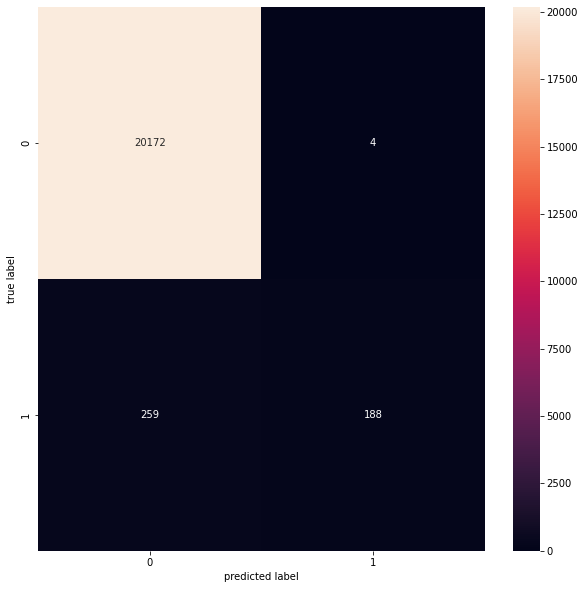

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score , confusion_matrix

conf_matrix = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(10,10))

sn.heatmap(conf_matrix, annot=True, ax=ax, fmt='g',vmin=0)
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")


## Refit best model

In [ ]:
rf = RandomForestClassifier(max_features='log2')
rf.fit(X_train, y_train)

preds = rf.predict(X_test)

print(f'accuracy : {accuracy_score(y_test,preds)}')
print(f'f1_score : {f1_score(y_test,preds)}')
print(classification_report(y_test , preds))

accuracy : 0.9892900411921492
f1_score : 0.6285714285714286
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     20228
           1       0.99      0.46      0.63       407

    accuracy                           0.99     20635
   macro avg       0.99      0.73      0.81     20635
weighted avg       0.99      0.99      0.99     20635



Text(0.5, 69.0, 'predicted label')

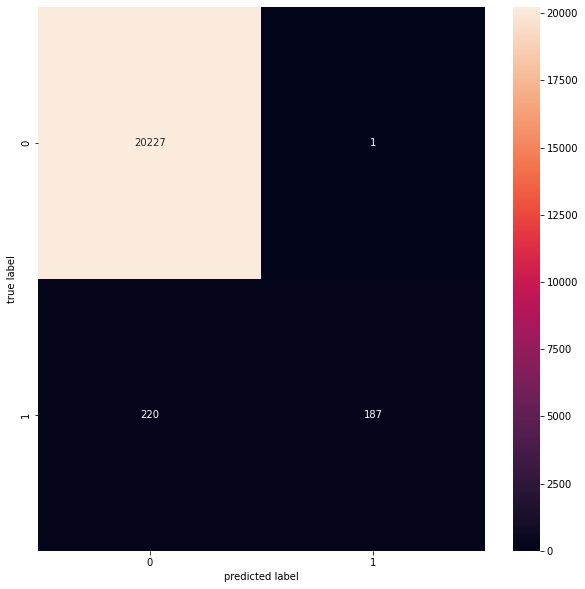

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score , confusion_matrix

conf_matrix = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(10,10))

sn.heatmap(conf_matrix, annot=True, ax=ax, fmt='g',vmin=0)
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")


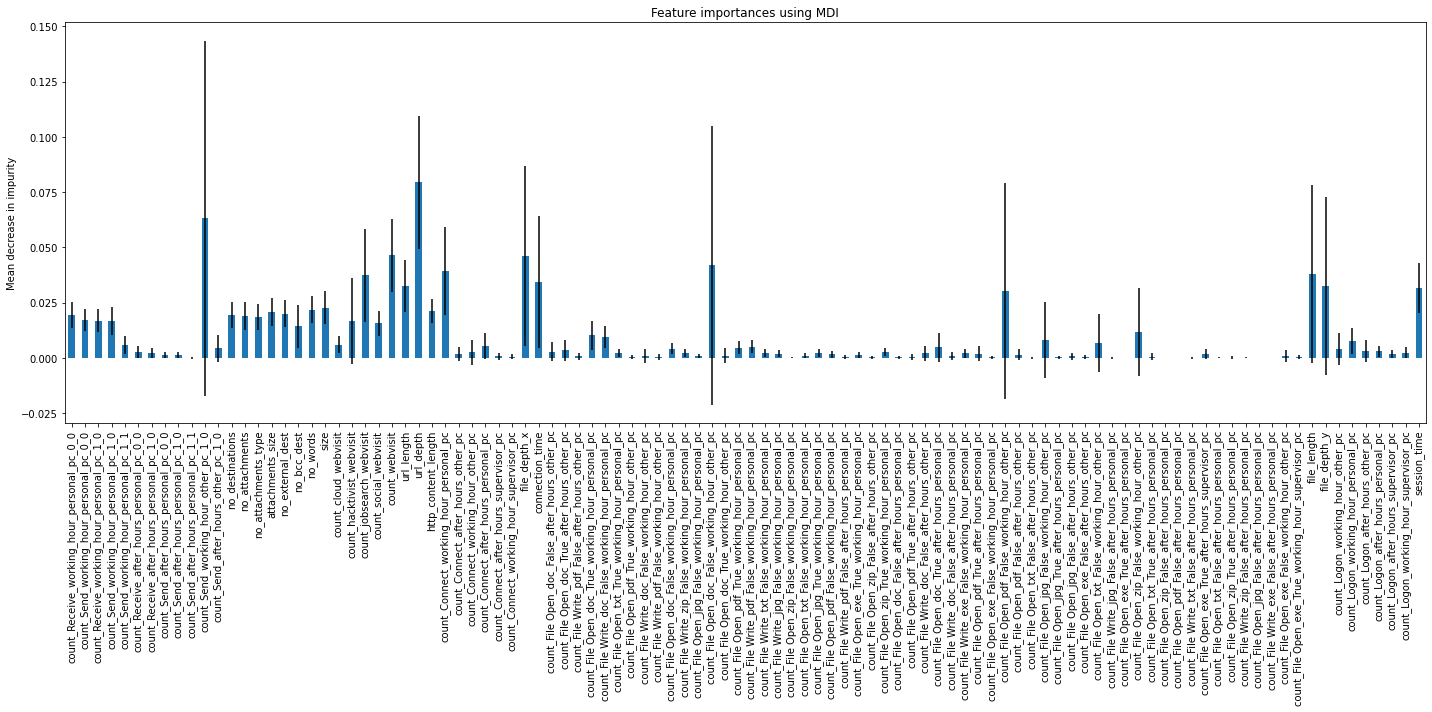

In [ ]:
feature_names = X_test.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(20, 10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
mis_clf = X_test[preds != y_test]

mis_clf_users = merged_features.iloc[mis_clf.index.values, :].user.unique()
mis_clf_df = insiders_df[insiders_df["user"].isin(mis_clf_users)]

all_users = merged_features.user.unique()
all_malicious_users_df = insiders_df[insiders_df["user"].isin(all_users)]

## Refit RF with top features

In [ ]:

best_feature_comb = {}
for i in range(5, 40):
  top_features = forest_importances.to_frame().sort_values(by=0, ascending=False).iloc[:i].index.values

  X_train_top_features = X_train[top_features]
  X_test_top_features = X_test[top_features]

  rf = RandomForestClassifier(max_features='log2')
  rf.fit(X_train_top_features, y_train)

  preds = rf.predict(X_test_top_features)
  f1 = f1_score(y_test,preds)
  print(f'f1_score for {i} : {f1}')
  best_feature_comb[i] = f1

f1_score for 5 : 0.8063241106719368
f1_score for 6 : 0.8503937007874016
f1_score for 7 : 0.8503311258278146
f1_score for 8 : 0.8495339547270305
f1_score for 9 : 0.845945945945946
f1_score for 10 : 0.841095890410959
f1_score for 11 : 0.8476454293628809
f1_score for 12 : 0.8354080221300139
f1_score for 13 : 0.8441379310344826
f1_score for 14 : 0.8180535966149507
f1_score for 15 : 0.8034433285509327
f1_score for 16 : 0.821529745042493
f1_score for 17 : 0.8180535966149507
f1_score for 18 : 0.8096590909090909
f1_score for 19 : 0.7977044476327115


Text(0.5, 69.0, 'predicted label')

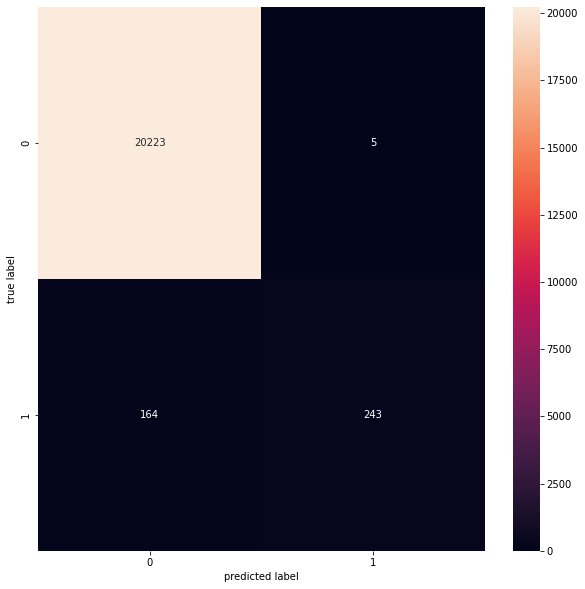

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score , confusion_matrix

conf_matrix = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(10,10))

sn.heatmap(conf_matrix, annot=True, ax=ax, fmt='g',vmin=0)
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")


## Basic Error Analysis
Attacks 4 and 1 are almost always detected, attack 2 which lasts for months 
is usually not detected. Note that some of the days may be detected but 
I am just counting the number of misclassified scenarios, so these plots may be decieving it's better to plot the missclassifications as daily densities.

In [ ]:
mis_clf.index.values

array([55682, 36707, 34306, 30714, 34340, 57437, 57028, 49752, 42592,
       44585, 50840, 52848, 29653, 31176, 46582, 45678, 34156, 43581,
       60868, 35264, 39808, 27666, 36250, 30713, 32377, 40925, 35698,
       59551, 36916, 57566, 56031, 31418, 34044, 37343, 28516, 30305,
       44744, 26273, 28462, 40124, 34380, 50352, 32701, 26286, 32342,
       28266, 43916, 37246, 47339, 55940, 54941, 50998, 43327, 27091,
       49460, 40822, 48277, 25667, 43266, 49027, 31200, 54578, 36789,
       30200, 51085, 29838, 42762, 33838, 37969, 44626, 31825, 27661,
       29213, 35878, 27287, 57378, 30452, 59681, 47155, 24847, 50783,
       35526, 40246, 41436, 44620, 32505, 48430, 45362, 31178, 38053,
       32760, 46168, 48739, 55491, 46848, 47215, 37169, 52697, 42917,
       31859, 39623, 34204, 57824, 52266, 30414, 59295, 55958, 29468,
       54848, 34388, 45742, 37593, 45398, 26647, 26482, 56036, 33219,
       54251, 27756, 40876, 58098, 32962, 34071, 40929, 30256, 34255,
       35348, 30643,

In [ ]:
mis_clf_users = merged_features.loc[mis_clf.index.values, "user"].unique()
mis_clf_df = insiders_df[insiders_df["user"].isin(mis_clf_users)]

all_users = merged_features.user.unique()
all_malicious_users_df = insiders_df[insiders_df["user"].isin(all_users)]

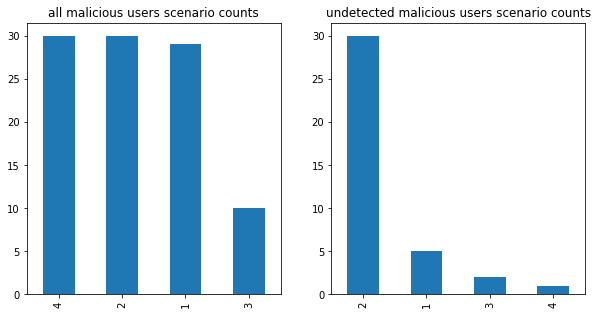

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
all_malicious_users_df['scenario'].value_counts().plot.bar(title='all malicious users scenario counts', ax=ax[0])
mis_clf_df['scenario'].value_counts().plot.bar(title='undetected malicious users scenario counts', ax=ax[1])

{21296, 29514, 33832, 45193, 59593}

In [ ]:
merged_features.loc[21296]

day                                           2010-06-02 00:00:00
user                                                      CKP0630
count_Receive_working_hour_personal_pc_0_0                    3.0
count_Send_working_hour_personal_pc_0_0                       0.0
count_Receive_working_hour_personal_pc_1_0                    1.0
                                                     ...         
count_Logon_after_hours_personal_pc                           0.0
count_Logon_after_hours_supervisor_pc                         0.0
count_Logon_working_hour_supervisor_pc                        0.0
session_time                                                476.0
is_malicious                                                    0
Name: 21296, Length: 105, dtype: object

In [ ]:
mis_clf_idxs

array([55682, 36707, 34306, 30714, 34340, 57437, 57028, 49752, 42592,
       44585, 50840, 52848, 29653, 31176, 46582, 45678, 34156, 43581,
       60868, 35264, 39808, 27666, 36250, 30713, 32377, 40925, 35698,
       59551, 36916, 57566, 56031, 31418, 34044, 37343, 28516, 30305,
       44744, 26273, 28462, 40124, 34380, 50352, 32701, 26286, 32342,
       28266, 43916, 37246, 47339, 55940, 54941, 50998, 43327, 27091,
       49460, 40822, 48277, 25667, 43266, 49027, 31200, 54578, 36789,
       30200, 51085, 29838, 42762, 33838, 37969, 44626, 31825, 27661,
       29213, 35878, 27287, 57378, 30452, 59681, 47155, 24847, 50783,
       35526, 40246, 41436, 44620, 32505, 48430, 45362, 31178, 38053,
       32760, 46168, 48739, 55491, 46848, 47215, 37169, 52697, 42917,
       31859, 39623, 34204, 57824, 52266, 30414, 59295, 55958, 29468,
       54848, 34388, 45742, 37593, 45398, 26647, 26482, 56036, 33219,
       54251, 27756, 40876, 58098, 32962, 34071, 40929, 30256, 34255,
       35348, 30643,

In [ ]:
test_malicious_idxs = X_test[y_test == 1].index.values
mis_clf_idxs = mis_clf.index.values

test_malicious_df = merged_features.loc[test_malicious_idxs]
test_malicious_df["scenario"] = test_malicious_df['user'].apply(lambda x: insiders_df[insiders_df['user']==x].scenario.values[0])
test_malicious_df["correctly_clf"] = [1] * test_malicious_df.shape[0]
test_malicious_df.loc[mis_clf_idxs, "correctly_clf"] = 0 

test_malicious_df

day     user  count_Receive_working_hour_personal_pc_0_0  \
42436 2010-11-09  HXP0976                                         9.0   
55682 2011-03-17  TMT0851                                        23.0   
55143 2011-03-11  WSK1857                                         4.0   
24651 2010-06-24  VCF1602                                        12.0   
36707 2010-09-23  CIF1430                                         3.0   
...          ...      ...                                         ...   
39621 2010-10-15  REF1924                                        14.0   
33676 2010-08-30  OSS1463                                         4.0   
28461 2010-07-22  TNB1616                                        19.0   
56657 2011-03-29  ASH0298                                        13.0   
32526 2010-08-20  OFS0030                                         5.0   

       count_Send_working_hour_personal_pc_0_0  \
42436                                      9.0   
55682                                      9.0   
55143                                      2.0   
24651                                      3.0   
36707                                      2.0   
...                                        ...   
39621                                      2.0   
33676                                      0.0   
28461                                      5.0   
56657                                      9.0   
32526                                      6.0   

       count_Receive_working_hour_personal_pc_1_0  \
42436                                         7.0   
55682                                        14.0   
55143                                         1.0   
24651                                        26.0   
36707                                         2.0   
...                                           ...   
39621                                        12.0   
33676                                         1.0   
28461                                        14.0   
56657                                        14.0   
32526                                         3.0   

       count_Send_working_hour_personal_pc_1_0  \
42436                                      0.0   
55682                                      6.0   
55143                                      1.0   
24651                                      4.0   
36707                                      1.0   
...                                        ...   
39621                                     13.0   
33676                                      0.0   
28461                                      7.0   
56657                                      5.0   
32526                                      3.0   

       count_Send_working_hour_personal_pc_1_1  \
42436                                      0.0   
55682                                      0.0   
55143                                      0.0   
24651                                      4.0   
36707                                      0.0   
...                                        ...   
39621                                      0.0   
33676                                      1.0   
28461                                      2.0   
56657                                      0.0   
32526                                      0.0   

       count_Receive_after_hours_personal_pc_0_0  \
42436                                        0.0   
55682                                        1.0   
55143                                        0.0   
24651                                        0.0   
36707                                        0.0   
...                                          ...   
39621                                        0.0   
33676                                        0.0   
28461                                        0.0   
56657                                        0.0   
32526                                        0.0   

       count_Receive_after_hours_personal_pc_1_0  \
42436              

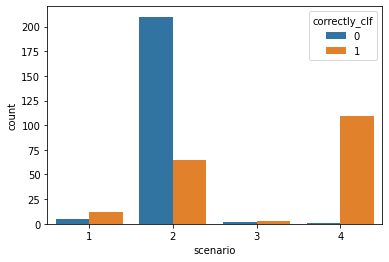

In [ ]:
import seaborn as sns
ax = sns.countplot(x="scenario", hue="correctly_clf", data=test_malicious_df)

In [ ]:
mis_clf_df = merged_features.iloc[mis_clf.index.values, :]
mis_clf_df["scenario"] = mis_clf_df['user'].apply(lambda x: insiders_df[insiders_df['user']==x].scenario.values[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


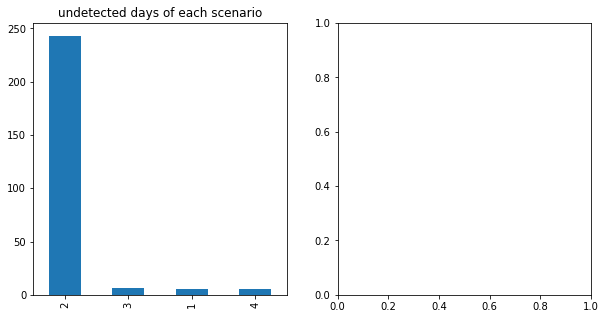

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
mis_clf_df.scenario.value_counts().plot.bar(title="undetected days of each scenario", ax=ax[0])
#merged_features.scenario.value_counts().plot.bar(title="undetected days of each scenario", ax=ax[0])


In [ ]:
mis_clf_df.shape

(11270, 97)

## Explainability

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 4.8 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=5d1e909294f12747d46b39d41b45903666a68d36d0803bf42620ec1d9145ce9a
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names=X_train.columns
                                                   , class_names=["benign", "malicious"],
                                                   discretize_continuous=True)

In [ ]:
i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test.iloc[i, :], rf.predict_proba, num_features=10, top_labels=1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
exp = explainer.explain_instance(X_test[y_test==1].iloc[0, :].to_numpy(), rf.predict_proba, num_features=5, top_labels=2)
exp.show_in_notebook(show_table=True, show_all=False)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
X_test[y_test==1].iloc[0, :].to_numpy()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.00000000e+00, 0.00000000e+00, 6.20000000e+01, 3.88300000e+04,
       5.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.00000000e+00, 4.12000000e+01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [ ]:
X_test[y_test==1]

count_Receive_working_hour_personal_pc_0_0  \
40594                                         0.0   
29464                                        19.0   
57731                                         4.0   
39862                                        13.0   
28845                                         2.0   
...                                           ...   
32505                                         1.0   
39912                                         1.0   
28657                                        13.0   
52123                                        15.0   
53163                                         4.0   

       count_Send_working_hour_personal_pc_0_0  \
40594                                      0.0   
29464                                     12.0   
57731                                      1.0   
39862                                      9.0   
28845                                      0.0   
...                                        ...   
32505                                      0.0   
39912                                      0.0   
28657                                      5.0   
52123                                     12.0   
53163                                      0.0   

       count_Receive_working_hour_personal_pc_1_0  \
40594                                         0.0   
29464                                        12.0   
57731                                         3.0   
39862                                        12.0   
28845                                         3.0   
...                                           ...   
32505                                         4.0   
39912                                         1.0   
28657                                         6.0   
52123                                        12.0   
53163                                         2.0   

       count_Send_working_hour_personal_pc_1_0  \
40594                                      1.0   
29464                                      3.0   
57731                                      0.0   
39862                                      6.0   
28845                                      1.0   
...                                        ...   
32505                                      0.0   
39912                                      1.0   
28657                                     12.0   
52123                                      1.0   
53163                                      1.0   

       count_Send_working_hour_personal_pc_1_1  \
40594                                      0.0   
29464                                      0.0   
57731                                      0.0   
39862                                      0.0   
28845                                      0.0   
...                                        ...   
32505                                      1.0   
39912                                      0.0   
28657                                      0.0   
52123                                      0.0   
53163                                      0.0   

       count_Receive_after_hours_personal_pc_0_0  \
40594                                        0.0   
29464                                        0.0   
57731                                        0.0   
39862                                        0.0   
28845                                        0.0   
...                                          ...   
32505                                        0.0   
39912                                        0.0   
28657                                        0.0   
52123                                        0.0   
53163                                        0.0   

       count_Receive_after_hours_personal_pc_1_0  \
40594                                        0.0   
29464                                        0.0   
57731                                        0.0   
39862                                        0.0   
28845                                        

# XGBOOST

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
forest_importances.to_frame().sort_values(by=0, ascending=False).iloc[:6].index.values

array(['url_depth', 'count_Send_working_hour_other_pc_1_0',
       'count_webvisit', 'file_depth_x',
       'count_File Open_doc_False_working_hour_other_pc',
       'count_Connect_working_hour_personal_pc'], dtype=object)

In [ ]:
# best 6 features
top_features = forest_importances.to_frame().sort_values(by=0, ascending=False).iloc[:6].index.values
X_train_top_features = X_train[top_features]
X_test_top_features = X_test[top_features]

In [ ]:
X_train_top_features.shape

(41895, 0)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {"subsample": np.arange(0.5,1,0.1), 
              "max_depth": np.arange(3,25),
              "n_estimators ":np.arange(50,300)}

              
xgboost_rand = RandomizedSearchCV(XGBClassifier(), param_distributions=param_grid,
                             verbose=2, scoring="f1_micro", n_iter=30)
xgboost_rand.fit(X_train_top_features, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .......max_depth=3, n_estimators =59, subsample=0.6; total time=   1.6s
[CV] END .......max_depth=3, n_estimators =59, subsample=0.6; total time=   1.6s
[CV] END .......max_depth=3, n_estimators =59, subsample=0.6; total time=   1.6s
[CV] END .......max_depth=3, n_estimators =59, subsample=0.6; total time=   1.5s
[CV] END .......max_depth=3, n_estimators =59, subsample=0.6; total time=   1.5s
[CV] END ......max_depth=23, n_estimators =78, subsample=0.5; total time=   3.9s
[CV] END ......max_depth=23, n_estimators =78, subsample=0.5; total time=   4.0s
[CV] END ......max_depth=23, n_estimators =78, subsample=0.5; total time=   3.9s
[CV] END ......max_depth=23, n_estimators =78, subsample=0.5; total time=   3.9s
[CV] END ......max_depth=23, n_estimators =78, subsample=0.5; total time=   3.9s
[CV] END .....max_depth=16, n_estimators =114, subsample=0.7; total time=   4.4s
[CV] END .....max_depth=16, n_estimators =114, 

RandomizedSearchCV(estimator=XGBClassifier(), n_iter=30,
                   param_distributions={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24]),
                                        'n_estimators ': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 10...
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
       271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283,
       284, 285, 286, 287, 288, 289, 290, 291, 292, 2

In [ ]:
xgboost_rand.best_estimator_

XGBClassifier(max_depth=16, n_estimators =188, subsample=0.6)

In [ ]:
xgboost = XGBClassifier(subsample= 0.6, max_depth= 16 , n_estimators=188)
xgboost.fit(X_train_top_features, y_train)

XGBClassifier(max_depth=16, n_estimators=188, subsample=0.6)

In [ ]:
xg_preds = xgboost.predict(X_test_top_features)
print(f'accuracy : {accuracy_score(y_test,xg_preds)}')
print(f'f1_score : {f1_score(y_test,xg_preds)}')
print(classification_report(y_test , xg_preds))

accuracy : 0.9947661739762539
f1_score : 0.8590078328981723
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20228
           1       0.92      0.81      0.86       407

    accuracy                           0.99     20635
   macro avg       0.96      0.90      0.93     20635
weighted avg       0.99      0.99      0.99     20635



Text(0.5, 69.0, 'predicted label')

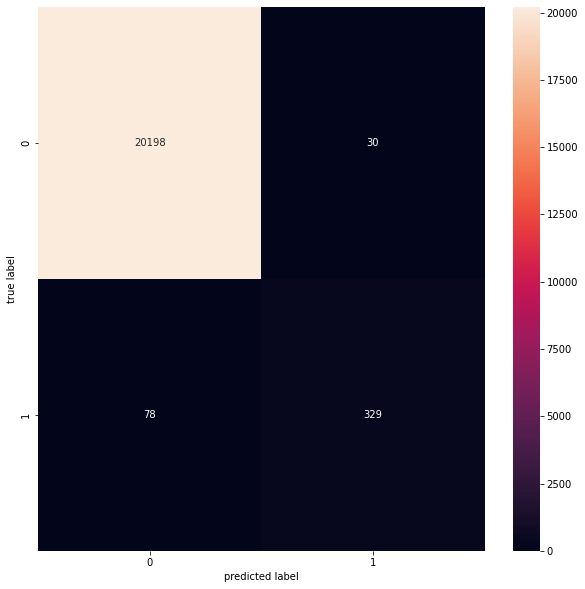

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score , confusion_matrix

conf_matrix = confusion_matrix(y_test, xg_preds)
fig, ax = plt.subplots(figsize=(10,10))

sn.heatmap(conf_matrix, annot=True, ax=ax, fmt='g',vmin=0)
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")


# CatBoost

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
# best 6 features
top_features = ['url_depth', 'count_Send_working_hour_other_pc_1_0',
       'count_webvisit', 'file_depth_x',
       'count_File Open_doc_False_working_hour_other_pc',
       'count_Connect_working_hour_personal_pc']
       
X_train_top_features = X_train[top_features]
X_test_top_features = X_test[top_features]

In [ ]:
from catboost import CatBoostClassifier
catBoost = CatBoostClassifier()

catBoost.fit(X_train_top_features, y_train)

Learning rate set to 0.050769
0:	learn: 0.5840177	total: 56.4ms	remaining: 56.4s
1:	learn: 0.5043170	total: 63.8ms	remaining: 31.8s
2:	learn: 0.4163493	total: 71.6ms	remaining: 23.8s
3:	learn: 0.3597625	total: 79.5ms	remaining: 19.8s
4:	learn: 0.2961707	total: 88.2ms	remaining: 17.5s
5:	learn: 0.2631861	total: 94.7ms	remaining: 15.7s
6:	learn: 0.2352654	total: 101ms	remaining: 14.4s
7:	learn: 0.2037818	total: 110ms	remaining: 13.7s
8:	learn: 0.1815153	total: 119ms	remaining: 13.1s
9:	learn: 0.1605366	total: 127ms	remaining: 12.6s
10:	learn: 0.1439819	total: 136ms	remaining: 12.3s
11:	learn: 0.1260279	total: 145ms	remaining: 11.9s
12:	learn: 0.1105930	total: 154ms	remaining: 11.7s
13:	learn: 0.1031791	total: 162ms	remaining: 11.4s
14:	learn: 0.0966238	total: 172ms	remaining: 11.3s
15:	learn: 0.0919525	total: 178ms	remaining: 11s
16:	learn: 0.0831715	total: 187ms	remaining: 10.8s
17:	learn: 0.0757426	total: 200ms	remaining: 10.9s
18:	learn: 0.0728399	total: 209ms	remaining: 10.8s
19:	lea

In [ ]:
cat_preds = catBoost.predict(X_test_top_features)
print(f'accuracy : {accuracy_score(y_test,cat_preds)}')
print(f'f1_score : {f1_score(y_test,cat_preds)}')
print(classification_report(y_test , cat_preds))

accuracy : 0.9952023261448995
f1_score : 0.8709256844850065
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20228
           1       0.93      0.82      0.87       407

    accuracy                           1.00     20635
   macro avg       0.96      0.91      0.93     20635
weighted avg       1.00      1.00      1.00     20635



Text(0.5, 69.0, 'predicted label')

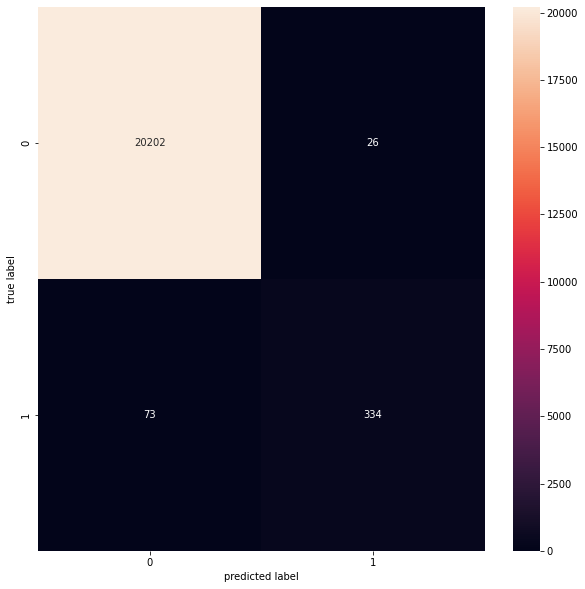

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score , confusion_matrix

conf_matrix = confusion_matrix(y_test, cat_preds)
fig, ax = plt.subplots(figsize=(10,10))

sn.heatmap(conf_matrix, annot=True, ax=ax, fmt='g',vmin=0)
ax.set_ylabel("true label")
ax.set_xlabel("predicted label")


##**Error Analysis**

In [ ]:
features = ['day','user','url_depth', 'count_Send_working_hour_other_pc_1_0',
       'count_webvisit', 'file_depth_x',
       'count_File Open_doc_False_working_hour_other_pc',
       'count_Connect_working_hour_personal_pc','is_malicious']

In [ ]:
final_df = merged_features.loc[:,features]
final_df.head(5)

day     user  url_depth  count_Send_working_hour_other_pc_1_0  \
0 2010-01-02  ELT1370        5.0                                   0.0   
1 2010-01-02  ESM1828        5.0                                   0.0   
2 2010-01-02  GVM1337        5.0                                   0.0   
3 2010-01-02  HJB1444        0.0                                   0.0   
4 2010-01-02  ILM1441        5.0                                   0.0   

   count_webvisit  file_depth_x  \
0             9.0           0.0   
1           153.0           3.0   
2            91.0           0.0   
3             0.0           0.0   
4            27.0           0.0   

   count_File Open_doc_False_working_hour_other_pc  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   count_Connect_working_hour_personal_pc  is_malicious  
0                                     0.0             0  
1                                     1.0             0  
2                                     0.0             0  
3                                     0.0             0  
4                                     0.0             0

In [ ]:
X_test_top_features

url_depth  count_Send_working_hour_other_pc_1_0  count_webvisit  \
9266         5.0                                   0.0            10.0   
58323        5.0                                   0.0           131.0   
26479        5.0                                   0.0            10.0   
36222        5.0                                   0.0            71.0   
48073        5.0                                   0.0           111.0   
...          ...                                   ...             ...   
20509        5.0                                   0.0           109.0   
37105        5.0                                   0.0            28.0   
32616        5.0                                   0.0            89.0   
4400         5.0                                   0.0           199.0   
12805        5.0                                   0.0            28.0   

       file_depth_x  count_File Open_doc_False_working_hour_other_pc  \
9266            0.0                                              0.0   
58323           0.0                                              0.0   
26479           0.0                                              0.0   
36222           3.0                                              0.0   
48073           2.0                                              0.0   
...             ...                                              ...   
20509           0.0                                              0.0   
37105           2.0                                              0.0   
32616           0.0                                              0.0   
4400            0.0                                              0.0   
12805           6.0                                              0.0   

       count_Connect_working_hour_personal_pc  
9266                                      0.0  
58323                                     0.0  
26479                                     0.0  
36222                                     5.0  
48073                                     0.0  
...                                       ...  
20509                                     0.0  
37105                                     8.0  
32616                                     0.0  
4400                                      0.0  
12805                                     2.0  

[20635 rows x 6 columns]

In [ ]:
malicious_X = X_test_top_features[y_test == 1]
malicious_y = y_test[y_test == 1]

malicious_preds = catBoost.predict(malicious_X)
mis_clf = malicious_X[malicious_y != malicious_preds]
mis_clf

url_depth  count_Send_working_hour_other_pc_1_0  count_webvisit  \
55682   4.974194                                   0.0           146.0   
36707   5.000000                                   0.0            29.0   
34306   5.000000                                   0.0            28.0   
34340   4.556701                                   0.0            86.0   
57437   4.821429                                   0.0           153.0   
...          ...                                   ...             ...   
41594   4.889535                                   0.0           159.0   
46841   5.000000                                   0.0            29.0   
39862   4.781818                                   0.0           153.0   
32661   3.725490                                   0.0            56.0   
28461   4.722222                                   0.0           179.0   

       file_depth_x  count_File Open_doc_False_working_hour_other_pc  \
55682           6.0                                              0.0   
36707           6.0                                              0.0   
34306           6.0                                              0.0   
34340           6.0                                              0.0   
57437           6.0                                              0.0   
...             ...                                              ...   
41594           0.0                                              0.0   
46841           2.0                                              0.0   
39862           5.0                                              0.0   
32661           6.0                                              0.0   
28461           0.0                                              0.0   

       count_Connect_working_hour_personal_pc  
55682                                     2.0  
36707                                     5.0  
34306                                     7.0  
34340                                     5.0  
57437                                     1.0  
...                                       ...  
41594                                     0.0  
46841                                     4.0  
39862                                     1.0  
32661                                     5.0  
28461                                     0.0  

[73 rows x 6 columns]

In [ ]:
mis_clf_users = merged_features.loc[mis_clf.index.values, "user"].unique()
mis_clf_df = insiders_df[insiders_df["user"].isin(mis_clf_users)]

all_users = merged_features.user.unique()
all_malicious_users_df = insiders_df[insiders_df["user"].isin(all_users)]

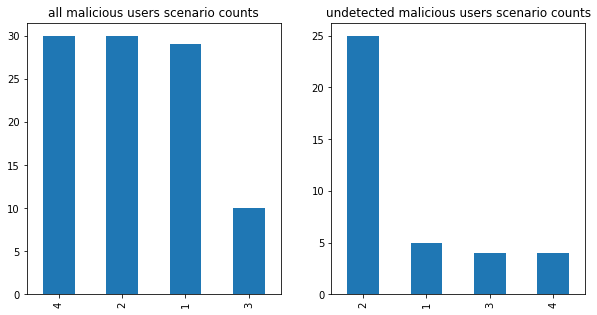

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
all_malicious_users_df['scenario'].value_counts().plot.bar(title='all malicious users scenario counts', ax=ax[0])
mis_clf_df['scenario'].value_counts().plot.bar(title='undetected malicious users scenario counts', ax=ax[1])

In [ ]:
test_malicious_idxs = X_test_top_features[y_test == 1].index.values
mis_clf_idxs = mis_clf.index.values

test_malicious_df = final_df.loc[test_malicious_idxs]
test_malicious_df["scenario"] = test_malicious_df['user'].apply(lambda x: insiders_df[insiders_df['user']==x].scenario.values[0])
test_malicious_df["correctly_clf"] = [1] * test_malicious_df.shape[0]
test_malicious_df.loc[mis_clf_idxs, "correctly_clf"] = 0 

test_malicious_df

day     user  url_depth  count_Send_working_hour_other_pc_1_0  \
42436 2010-11-09  HXP0976   4.862745                                   0.0   
55682 2011-03-17  TMT0851   4.974194                                   0.0   
55143 2011-03-11  WSK1857   5.033333                                   0.0   
24651 2010-06-24  VCF1602   4.940120                                   0.0   
36707 2010-09-23  CIF1430   5.000000                                   0.0   
...          ...      ...        ...                                   ...   
39621 2010-10-15  REF1924   5.006289                                   0.0   
33676 2010-08-30  OSS1463   5.000000                                   0.0   
28461 2010-07-22  TNB1616   4.722222                                   0.0   
56657 2011-03-29  ASH0298   5.000000                                   1.0   
32526 2010-08-20  OFS0030   4.515789                                   1.0   

       count_webvisit  file_depth_x  \
42436            86.0           3.0   
55682           146.0           6.0   
55143            24.0           2.0   
24651           164.0           2.0   
36707            29.0           6.0   
...               ...           ...   
39621           145.0           0.0   
33676            10.0           6.0   
28461           179.0           0.0   
56657           141.0           0.0   
32526            84.0           0.0   

       count_File Open_doc_False_working_hour_other_pc  \
42436                                              0.0   
55682                                              0.0   
55143                                              0.0   
24651                                              0.0   
36707                                              0.0   
...                                                ...   
39621                                              0.0   
33676                                              0.0   
28461                                              0.0   
56657                                              4.0   
32526                                              2.0   

       count_Connect_working_hour_personal_pc  is_malicious  scenario  \
42436                                     5.0             1         2   
55682                                     2.0             1         2   
55143                                     0.0             1         1   
24651                                     5.0             1         2   
36707                                     5.0             1         2   
...                                       ...           ...       ...   
39621                                     0.0             1         1   
33676                                     6.0             1         2   
28461                                     0.0             1         2   
56657                                     0.0             1         4   
32526                                     0.0             1         4   

       correctly_clf  
42436              1  
55682              0  
55143              1  
24651              1  
36707              0  
...              ...  
39621              1  
33676              1  
28461              0  
56657              1  
32526              1  

[407 rows x 11 columns]

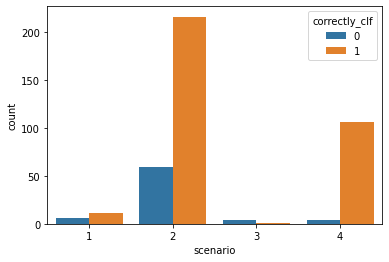

In [ ]:
import seaborn as sns
ax = sns.countplot(x="scenario", hue="correctly_clf", data=test_malicious_df)

In [ ]:
mis_clf_df = final_df.iloc[mis_clf.index.values, :]
mis_clf_df["scenario"] = mis_clf_df['user'].apply(lambda x: insiders_df[insiders_df['user']==x].scenario.values[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
probs = catBoost.predict_proba(malicious_X.loc[mis_clf.index.values])[:, 0]
probs


array([0.90016712, 0.97126781, 0.97822026, 0.62812588, 0.95697719,
       0.93427494, 0.91522336, 0.98755678, 0.55914154, 0.99911042,
       0.95127571, 0.94974346, 0.98535924, 0.98445504, 0.91450813,
       0.86382178, 0.91726676, 0.80272804, 0.95078837, 0.71637098,
       0.58124657, 0.74422316, 0.98962396, 0.9701016 , 0.8998534 ,
       0.98042648, 0.99403457, 0.9929509 , 0.99861609, 0.52146545,
       0.98645841, 0.99120398, 0.9935792 , 0.89482719, 0.86673721,
       0.87869162, 0.99919718, 0.95814421, 0.93427494, 0.75426929,
       0.99900871, 0.78893335, 0.91871577, 0.99847679, 0.93944356,
       0.99959208, 0.99974876, 0.97646846, 0.98955524, 0.50688768,
       0.92950272, 0.99771217, 0.6725865 , 0.68266402, 0.98042648,
       0.83605891, 0.98683798, 0.9885958 , 0.95814421, 0.7933613 ,
       0.98014977, 0.9244012 , 0.96907262, 0.98042648, 0.99869853,
       0.99469295, 0.7136979 , 0.98017259, 0.98235408, 0.99421767,
       0.87123099, 0.81611724, 0.9962636 ])

In [ ]:
final_df.head()

day     user  url_depth  count_Send_working_hour_other_pc_1_0  \
0 2010-01-02  ELT1370        5.0                                   0.0   
1 2010-01-02  ESM1828        5.0                                   0.0   
2 2010-01-02  GVM1337        5.0                                   0.0   
3 2010-01-02  HJB1444        0.0                                   0.0   
4 2010-01-02  ILM1441        5.0                                   0.0   

   count_webvisit  file_depth_x  \
0             9.0           0.0   
1           153.0           3.0   
2            91.0           0.0   
3             0.0           0.0   
4            27.0           0.0   

   count_File Open_doc_False_working_hour_other_pc  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   count_Connect_working_hour_personal_pc  is_malicious  
0                                     0.0             0  
1                                     1.0             0  
2                                     0.0             0  
3                                     0.0             0  
4                                     0.0             0

In [ ]:
features

['day',
 'user',
 'url_depth',
 'count_Send_working_hour_other_pc_1_0',
 'count_webvisit',
 'file_depth_x',
 'count_File Open_doc_False_working_hour_other_pc',
 'count_Connect_working_hour_personal_pc',
 'is_malicious']

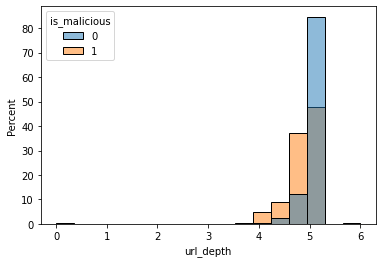

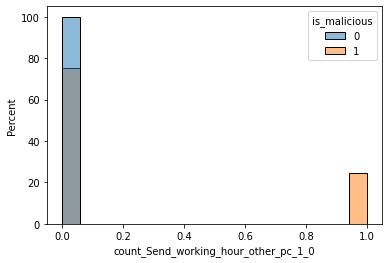

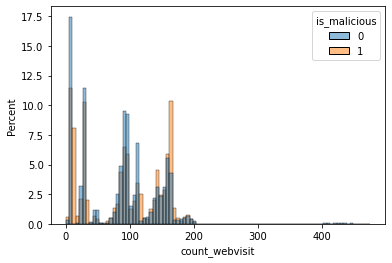

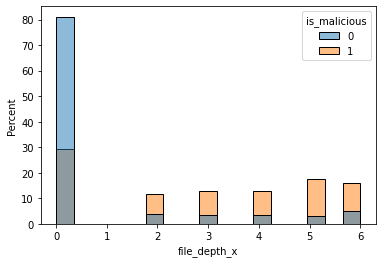

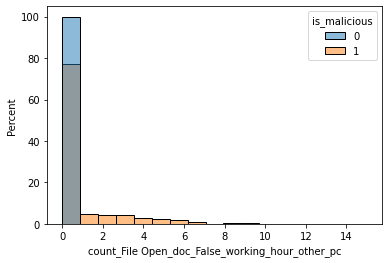

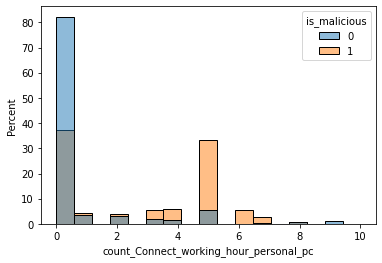

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scenario 3 always lasts 1 day
for f in features[2:-1]:
  sns.histplot(final_df, x=f, hue="is_malicious", palette='tab10',stat = 'percent' , common_norm = False)
  plt.show()

In [ ]:
# plot over time
mis_clf_dataframe = test_malicious_df[test_malicious_df['correctly_clf']==0]
mis_clf_dataframe.head()

day     user  url_depth  count_Send_working_hour_other_pc_1_0  \
55682 2011-03-17  TMT0851   4.974194                                   0.0   
36707 2010-09-23  CIF1430   5.000000                                   0.0   
34306 2010-09-03  CIF1430   5.000000                                   0.0   
34340 2010-09-03  GWG0497   4.556701                                   0.0   
57437 2011-04-05  TMT0851   4.821429                                   0.0   

       count_webvisit  file_depth_x  \
55682           146.0           6.0   
36707            29.0           6.0   
34306            28.0           6.0   
34340            86.0           6.0   
57437           153.0           6.0   

       count_File Open_doc_False_working_hour_other_pc  \
55682                                              0.0   
36707                                              0.0   
34306                                              0.0   
34340                                              0.0   
57437                                              0.0   

       count_Connect_working_hour_personal_pc  is_malicious  scenario  \
55682                                     2.0             1         2   
36707                                     5.0             1         2   
34306                                     7.0             1         2   
34340                                     5.0             1         2   
57437                                     1.0             1         2   

       correctly_clf  
55682              0  
36707              0  
34306              0  
34340              0  
57437              0

In [ ]:
mis_clf_users = mis_clf_dataframe['user'].unique()
mis_clf_users

array(['TMT0851', 'CIF1430', 'GWG0497', 'JAL0811', 'JUP1472', 'CWW1120',
       'OSS1463', 'CKP0630', 'TRC1838', 'TNB1616', 'CHP1711', 'ZEH0685',
       'OKM1092', 'HSN0675', 'SNK1280', 'RRS0056', 'LVF1626', 'ITA0159',
       'MDS0680', 'DNJ0740', 'ACM1770', 'VAH1292', 'MGB1235', 'KCM0466',
       'WDT1634', 'JCC0016', 'EPG1196', 'ISW0738', 'VCF1602', 'HIS1394',
       'JNR1592', 'NAH1366', 'BDP0096', 'MPF0690', 'ZIE0741', 'SIS0042',
       'HMS1658', 'BYO1846'], dtype=object)

In [ ]:
user = 'TMT0851'
scenario_df = mal_users_events[user] 
days = mis_clf_dataframe[(mis_clf_dataframe['user']==user) & (mis_clf_dataframe['correctly_clf']==0) ]['day']
mis_clf_days = [day.date() for day in days]

scenario_df['correcly_classified'] = scenario_df['day'].apply(lambda x :0 if x in mis_clf_days else 1 )
scenario_df

# group by day
user_scenario_df = scenario_df.groupby(['day'], sort=True)['correcly_classified'].max().to_frame('correctly_classified')
user_scenario_df.head()

correctly_classified
day                             
2011-03-14                     0
2011-03-15                     1
2011-03-16                     1
2011-03-17                     0
2011-03-18                     1

1    18
0    11
Name: correctly_classified, dtype: int64


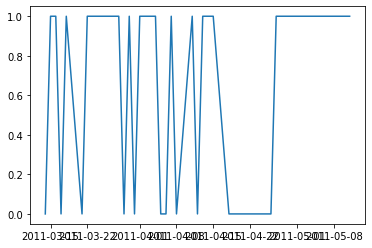

<Figure size 1440x1440 with 0 Axes>

In [ ]:
print(user_scenario_df['correctly_classified'].value_counts())

plt.plot(user_scenario_df.index , user_scenario_df['correctly_classified'])
plt.figure(figsize=(20,20))
plt.show()

1    18
0    11
Name: correctly_classified, dtype: int64


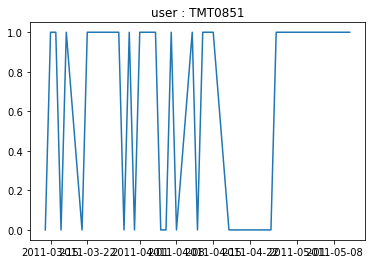

1    28
0     3
Name: correctly_classified, dtype: int64


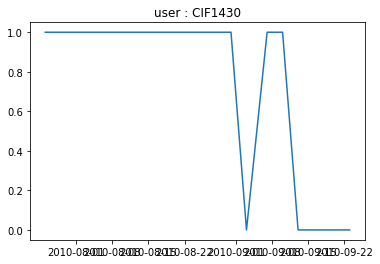

1    21
0     7
Name: correctly_classified, dtype: int64


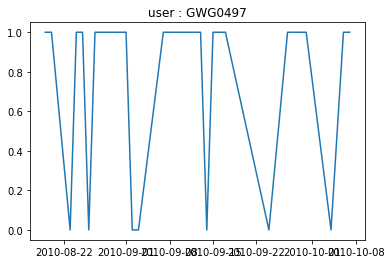

1    27
0     3
Name: correctly_classified, dtype: int64


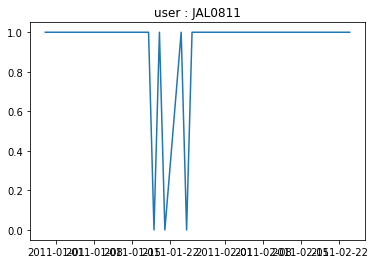

1    3
0    1
Name: correctly_classified, dtype: int64


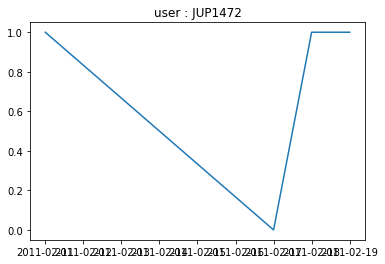

1    1
0    1
Name: correctly_classified, dtype: int64


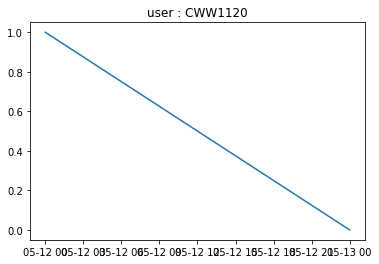

1    30
0     2
Name: correctly_classified, dtype: int64


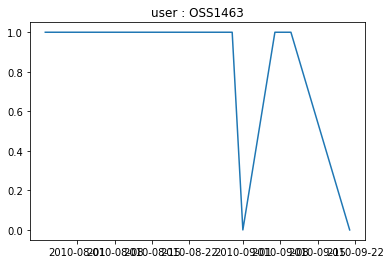

1    27
0     2
Name: correctly_classified, dtype: int64


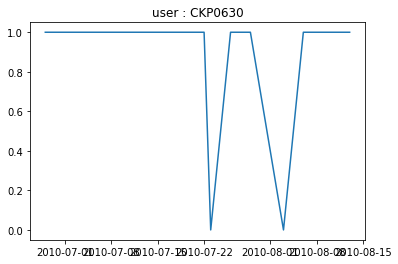

1    26
0     1
Name: correctly_classified, dtype: int64


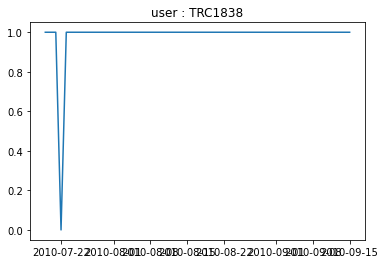

1    25
0     4
Name: correctly_classified, dtype: int64


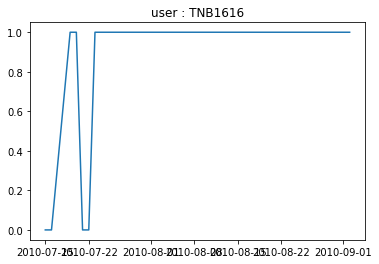

1    27
0     1
Name: correctly_classified, dtype: int64


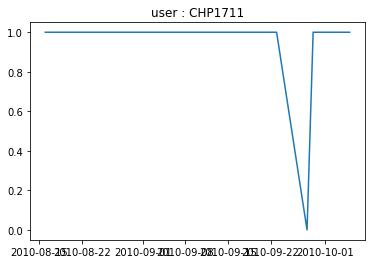

0    1
1    1
Name: correctly_classified, dtype: int64


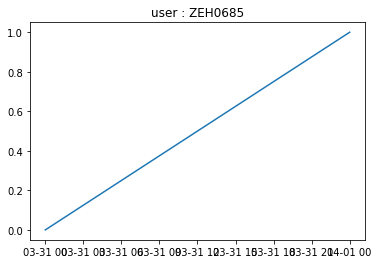

1    30
0     1
Name: correctly_classified, dtype: int64


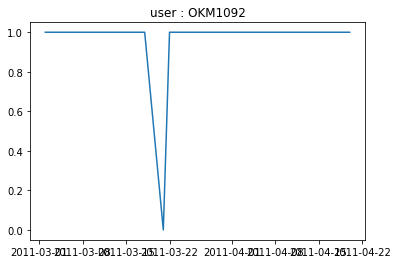

1    24
0     5
Name: correctly_classified, dtype: int64


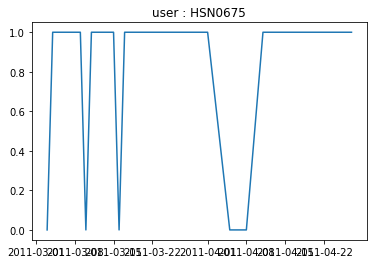

1    24
0     1
Name: correctly_classified, dtype: int64


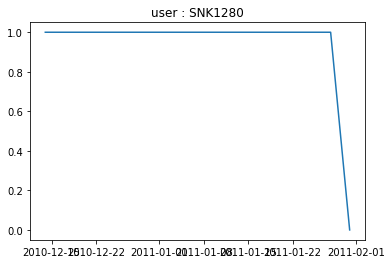

1    27
0     3
Name: correctly_classified, dtype: int64


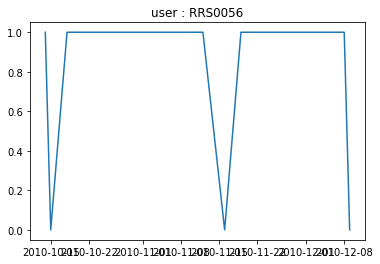

1    24
0     1
Name: correctly_classified, dtype: int64


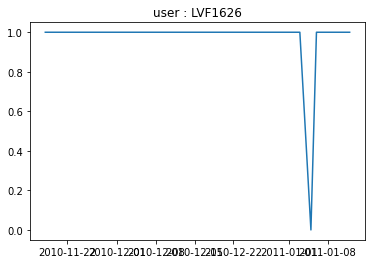

1    28
0     1
Name: correctly_classified, dtype: int64


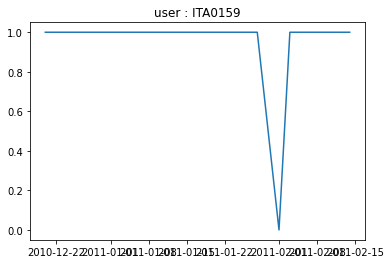

1    28
0     2
Name: correctly_classified, dtype: int64


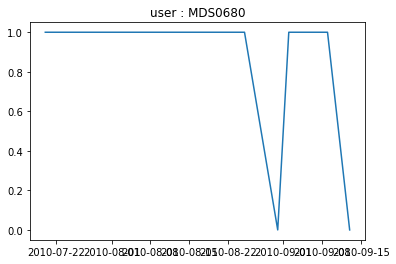

0    1
1    1
Name: correctly_classified, dtype: int64


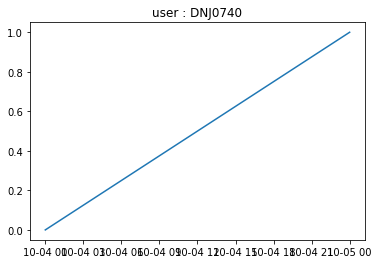

1    8
0    1
Name: correctly_classified, dtype: int64


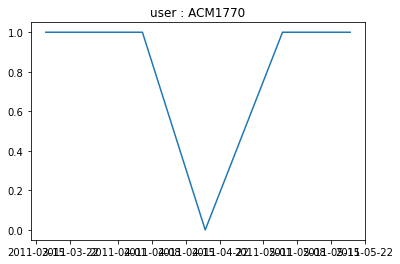

1    3
0    1
Name: correctly_classified, dtype: int64


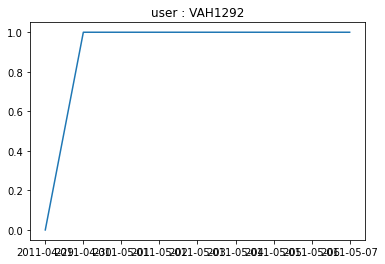

1    24
0     1
Name: correctly_classified, dtype: int64


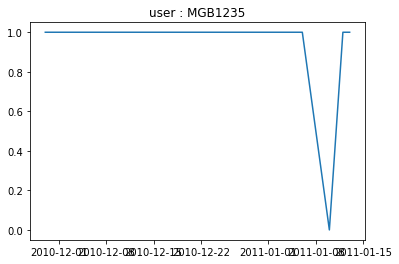

1    1
0    1
Name: correctly_classified, dtype: int64


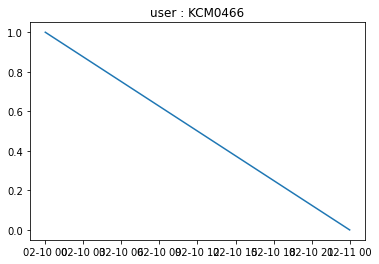

1    26
0     1
Name: correctly_classified, dtype: int64


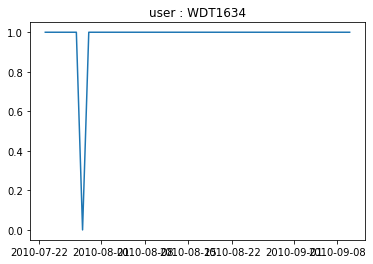

1    12
0     1
Name: correctly_classified, dtype: int64


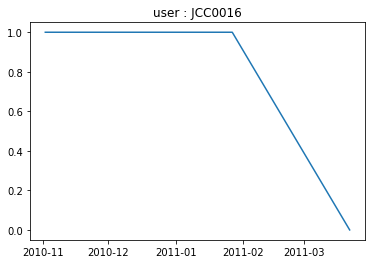

0    2
1    1
Name: correctly_classified, dtype: int64


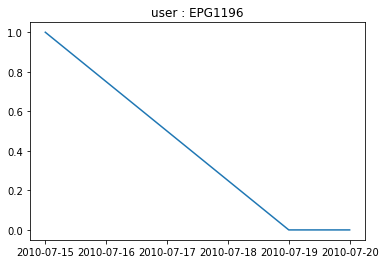

1    2
0    1
Name: correctly_classified, dtype: int64


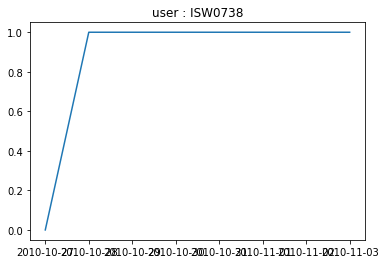

1    32
0     1
Name: correctly_classified, dtype: int64


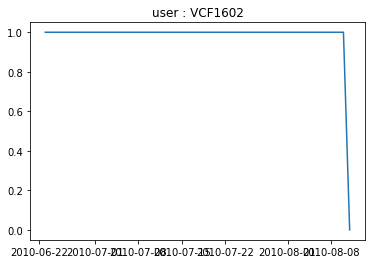

1    29
0     2
Name: correctly_classified, dtype: int64


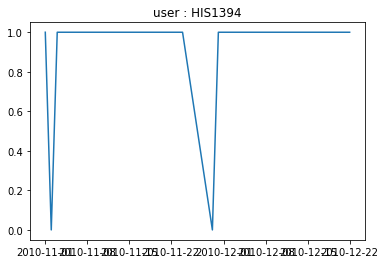

1    14
0     1
Name: correctly_classified, dtype: int64


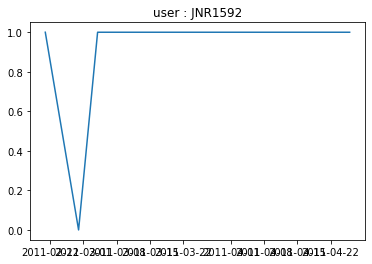

1    28
0     2
Name: correctly_classified, dtype: int64


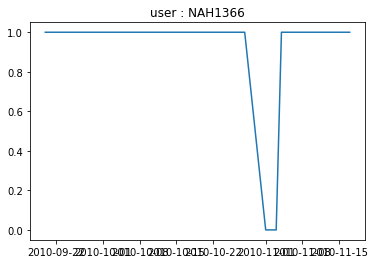

1    14
0     1
Name: correctly_classified, dtype: int64


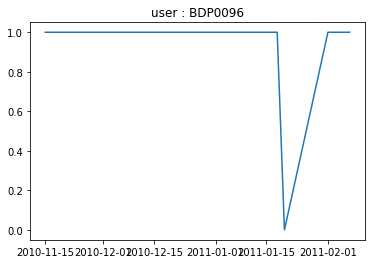

0    1
1    1
Name: correctly_classified, dtype: int64


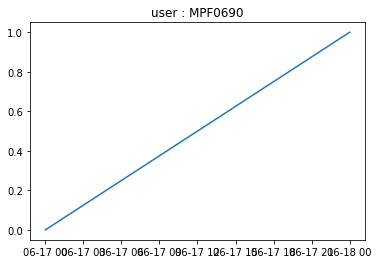

1    30
0     1
Name: correctly_classified, dtype: int64


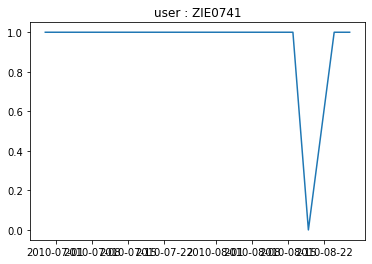

1    22
0     1
Name: correctly_classified, dtype: int64


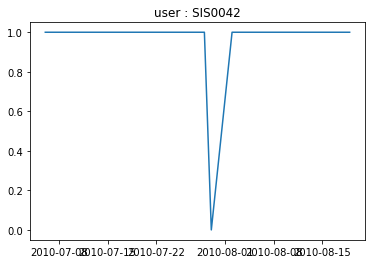

1    26
0     1
Name: correctly_classified, dtype: int64


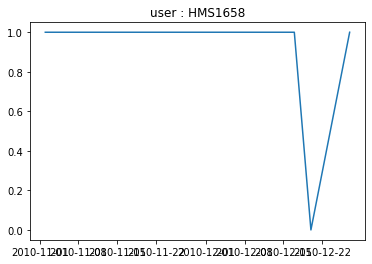

1    27
0     1
Name: correctly_classified, dtype: int64


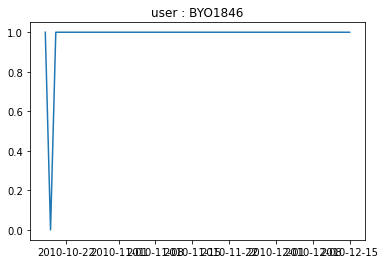

In [ ]:
for user in mis_clf_dataframe['user'].unique():
  scenario_df = mal_users_events[user] 
  days = mis_clf_dataframe[(mis_clf_dataframe['user']==user) & (mis_clf_dataframe['correctly_clf']==0) ]['day']
  mis_clf_days = [day.date() for day in days]

  scenario_df['correcly_classified'] = scenario_df['day'].apply(lambda x :0 if x in mis_clf_days else 1 )

  # group by day
  user_scenario_df = scenario_df.groupby(['day'], sort=True)['correcly_classified'].max().to_frame('correctly_classified')

  print(user_scenario_df['correctly_classified'].value_counts())

  plt.plot(user_scenario_df.index , user_scenario_df['correctly_classified'])
  plt.title(f'user : {user}')
  plt.show()

In [ ]:
insiders_df[]

In [ ]:
events_classified_benign = [mal_users_events[user] for user in mis_clf_dataframe['user'].unique()]
scenario_df = pd.concat(events_classified_benign)
scenario_df = pd.concat(events_classified_benign)